In [1]:
!pip install pydicom
!pip install torch
#!pip install ultralytics
!pip install segmentation-models-pytorch
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt
import os
import time
import numpy as np
import glob
import json
import collections
import torch
import torch.nn as nn

import pydicom as dicom
import matplotlib.patches as patches

from matplotlib import animation, rc
import pandas as pd

import pydicom as dicom # dicom
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_data=pd.read_csv("/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/train_data.csv")

In [5]:
def load_dicom(path):
    dicom = pydicom.dcmread(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

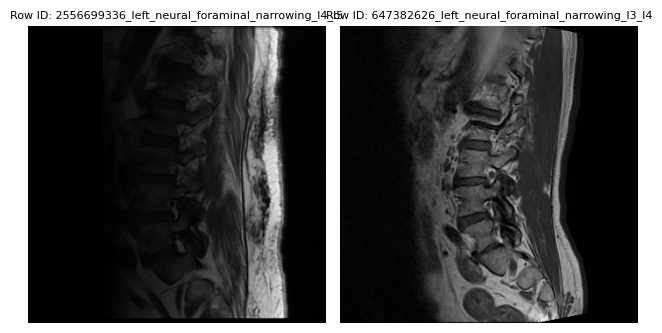

In [ ]:
import random
images = []
row_ids = []
selected_indices = random.sample(range(len(train_data)), 2)
for i in selected_indices:
    image = load_dicom(train_data['image_path'][i])
    images.append(image)
    row_ids.append(train_data['row_id'][i])

# Plot images
fig, ax = plt.subplots(1, 2)  # 1 row, 2 columns

for i in range(2):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_title(f'Row ID: {row_ids[i]}', fontsize=8)
    ax[i].axis('off')


plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.transforms import RandAugment
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from PIL import Image
import torch
import numpy as np
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, check):
        self.dataframe = dataframe
        self.check = check

        self.train_transform = A.Compose([
        A.Resize(640, 640),
        A.HorizontalFlip(p=0.3),  # Reduced from 50% to 30%
        A.Rotate(limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.3),  # Reduced rotation limit
        A.ColorJitter(brightness=0.1, contrast=0.1, p=0.3),  # Reduced intensity & probability
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
        ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

        self.val_transform = A.Compose([
        A.Resize(640, 640),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
        ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['image_path'][index]
        x = self.dataframe['x'][index]
        y = self.dataframe['y'][index]
        image = load_dicom(image_path)

        # Convert to OpenCV format for Albumentations**
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # DICOM grayscale -> RGB

        h, w, _ = image.shape  # Original size

        keypoints = [(x, y)]  # Single keypoint



        if self.check == 't':
            transformed = self.train_transform(image=image, keypoints=keypoints)
        else:
            transformed = self.val_transform(image=image, keypoints=keypoints)



        image = transformed['image']

        keypoints = transformed['keypoints']

        # ** Extract updated x, y coordinates**
        x_new, y_new = keypoints[0]

        return image, x_new, y_new


def create_datasets_and_loaders(df, condition, batch_size=32):
    filtered_df = df[df['condition'] == condition].reset_index(drop=True)
    l1=filtered_df[filtered_df['level'] == 'L1/L2'].reset_index(drop=True)
    l2=filtered_df[filtered_df['level'] == 'L2/L3'].reset_index(drop=True)
    l3=filtered_df[filtered_df['level'] == 'L3/L4'].reset_index(drop=True)
    l4=filtered_df[filtered_df['level'] == 'L4/L5'].reset_index(drop=True)
    l5=filtered_df[filtered_df['level'] == 'L5/S1'].reset_index(drop=True)

    # Create train/validation split
    train_dfl1, val_dfl1 = train_test_split(l1, test_size=0.2, random_state=42)
    train_dfl2, val_dfl2 = train_test_split(l2, test_size=0.2, random_state=42)
    train_dfl3, val_dfl3 = train_test_split(l3, test_size=0.2, random_state=42)
    train_dfl4, val_dfl4 = train_test_split(l4, test_size=0.2, random_state=42)
    train_dfl5, val_dfl5 = train_test_split(l5, test_size=0.2, random_state=42)

    train_dfl1 = train_dfl1.reset_index(drop=True)
    val_dfl1 = val_dfl1.reset_index(drop=True)
    train_dfl2 = train_dfl2.reset_index(drop=True)
    val_dfl2 = val_dfl2.reset_index(drop=True)
    train_dfl3 = train_dfl3.reset_index(drop=True)
    val_dfl3 = val_dfl3.reset_index(drop=True)
    train_dfl4 = train_dfl4.reset_index(drop=True)
    val_dfl4 = val_dfl4.reset_index(drop=True)
    train_dfl5 = train_dfl5.reset_index(drop=True)
    val_dfl5 = val_dfl5.reset_index(drop=True)


    # Create dataset objects
    train_datasetl1 = CustomDataset(train_dfl1,'t')
    val_datasetl1 = CustomDataset(val_dfl1,'v')
    train_datasetl2 = CustomDataset(train_dfl2,'t')
    val_datasetl2 = CustomDataset(val_dfl2,'v')
    train_datasetl3 = CustomDataset(train_dfl3,'t')
    val_datasetl3 = CustomDataset(val_dfl3,'v')
    train_datasetl4 = CustomDataset(train_dfl4,'t')
    val_datasetl4 = CustomDataset(val_dfl4,'v')
    train_datasetl5 = CustomDataset(train_dfl5,'t')
    val_datasetl5 = CustomDataset(val_dfl5,'v')

    # Create dataloaders
    trainloaderl1 = DataLoader(train_datasetl1, batch_size=batch_size, shuffle=True,  num_workers=2)
    valloaderl1 = DataLoader(val_datasetl1, batch_size=batch_size, shuffle=False, num_workers=2)
    trainloaderl2 = DataLoader(train_datasetl2, batch_size=batch_size, shuffle=True,  num_workers=2)
    valloaderl2 = DataLoader(val_datasetl2, batch_size=batch_size, shuffle=False, num_workers=2)
    trainloaderl3 = DataLoader(train_datasetl3, batch_size=batch_size, shuffle=True,  num_workers=2)
    valloaderl3 = DataLoader(val_datasetl3, batch_size=batch_size, shuffle=False, num_workers=2)
    trainloaderl4 = DataLoader(train_datasetl4, batch_size=batch_size, shuffle=True,  num_workers=2)
    valloaderl4 = DataLoader(val_datasetl4, batch_size=batch_size, shuffle=False, num_workers=2)
    trainloaderl5 = DataLoader(train_datasetl5, batch_size=batch_size, shuffle=True,  num_workers=2)
    valloaderl5 = DataLoader(val_datasetl5, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloaderl1, valloaderl1, len(train_dfl1), len(val_dfl1),  trainloaderl2, valloaderl2, len(train_dfl2), len(val_dfl2), trainloaderl3, valloaderl3, len(train_dfl3), len(val_dfl3), trainloaderl4, valloaderl4, len(train_dfl4), len(val_dfl4), trainloaderl5, valloaderl5, len(train_dfl5), len(val_dfl5)

# Create dataloaders for each series description
dataloaders = {}
lengths = {}

trainloader_t2stirl1, valloader_t2stirl1, len_train_t2stirl1, len_val_t2stirl1, trainloader_t2stirl2, valloader_t2stirl2, len_train_t2stirl2, len_val_t2stirl2, trainloader_t2stirl3, valloader_t2stirl3, len_train_t2stirl3, len_val_t2stirl3, trainloader_t2stirl4, valloader_t2stirl4, len_train_t2stirl4, len_val_t2stirl4, trainloader_t2stirl5, valloader_t2stirl5, len_train_t2stirl5, len_val_t2stirl5 = create_datasets_and_loaders(train_data, 'Spinal Canal Stenosis')
trainloader_t2leftl1, valloader_t2leftl1, len_train_t2leftl1, len_val_t2leftl1, trainloader_t2leftl2, valloader_t2leftl2, len_train_t2leftl2, len_val_t2leftl2, trainloader_t2leftl3, valloader_t2leftl3, len_train_t2leftl3, len_val_t2leftl3, trainloader_t2leftl4, valloader_t2leftl4, len_train_t2leftl4, len_val_t2leftl4, trainloader_t2leftl5, valloader_t2leftl5, len_train_t2leftl5, len_val_t2leftl5 = create_datasets_and_loaders(train_data, 'Left Subarticular Stenosis')
trainloader_t2rightl1, valloader_t2rightl1, len_train_t2rightl1, len_val_t2rightl1, trainloader_t2rightl2, valloader_t2rightl2, len_train_t2rightl2, len_val_t2rightl2, trainloader_t2rightl3, valloader_t2rightl3, len_train_t2rightl3, len_val_t2rightl3, trainloader_t2rightl4, valloader_t2rightl4, len_train_t2rightl4, len_val_t2rightl4, trainloader_t2rightl5, valloader_t2rightl5, len_train_t2rightl5, len_val_t2rightl5 = create_datasets_and_loaders(train_data, 'Right Subarticular Stenosis')
trainloader_t1leftl1, valloader_t1leftl1, len_train_t1leftl1, len_val_t1leftl1, trainloader_t1leftl2, valloader_t1leftl2, len_train_t1leftl2, len_val_t1leftl2, trainloader_t1leftl3, valloader_t1leftl3, len_train_t1leftl3, len_val_t1leftl3, trainloader_t1leftl4, valloader_t1leftl4, len_train_t1leftl4, len_val_t1leftl4, trainloader_t1leftl5, valloader_t1leftl5, len_train_t1leftl5, len_val_t1leftl5 = create_datasets_and_loaders(train_data, 'Left Neural Foraminal Narrowing')
trainloader_t1rightl1, valloader_t1rightl1, len_train_t1rightl1, len_val_t1rightl1, trainloader_t1rightl2, valloader_t1rightl2, len_train_t1rightl2, len_val_t1rightl2, trainloader_t1rightl3, valloader_t1rightl3, len_train_t1rightl3, len_val_t1rightl3, trainloader_t1rightl4, valloader_t1rightl4, len_train_t1rightl4, len_val_t1rightl4, trainloader_t1rightl5, valloader_t1rightl5, len_train_t1rightl5, len_val_t1rightl5 = create_datasets_and_loaders(train_data, 'Right Neural Foraminal Narrowing')


In [ ]:
import torch
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO("yolov8m").model

#  Print entire model structure
print(" Model Structure:\n")
print(model)  # This prints the overall model architecture

#  Print each layer inside the model in detail
print("\n✅ Detailed Layer Structure:\n")
for i, layer in enumerate(model.children()):
    print(f"Layer {i}: {layer}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 49.7M/49.7M [00:00<00:00, 192MB/s]


✅ Model Structure:

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inpla

In [ ]:
from ultralytics import YOLO

class MultiHeadYOLO(nn.Module):
    def __init__(self):
        """"""
        Custom YOLOv8 model with multiple heads for coordinate regression.

        :param desc: Model description, determines the head structure.
        :param yolov8_version: YOLOv8 model variant (e.g., "yolov8n", "yolov8m").
        """"""
        super(MultiHeadYOLO, self).__init__()

        # Load YOLOv8 backbone (feature extractor)
        self.mode='0'
        self.base_model = YOLO("yolov8m").model

        # Extract only the feature extraction layers (remove detection head)
        self.feature_extractor = nn.Sequential(*list(self.base_model.model[:10]))  # ✅ Only first 10 layers!

        # Freeze first few layers for stable training, unfreeze deeper layers
        for param in list(self.feature_extractor.parameters())[:5]:
            param.requires_grad = False  # Freeze first 5 layers
        for param in list(self.feature_extractor.parameters())[5:]:
            param.requires_grad = True

  # **Determine the feature size dynamically**
        dummy_input = torch.randn(1, 3, 640, 640)  # Test with a sample image
        features = self.feature_extractor(dummy_input)
        in_features = features.shape[1]  # Extract feature map channel size


        self.heads = nn.ModuleDict({
            str(i): self._create_head(in_features) for i in range(1, 6)  # Assuming feature size = 576
        })


    def _create_head(self, in_features):
        """"""Helper function to create a single regression head.""""""
        return nn.Sequential(
            #nn.AdaptiveAvgPool2d(1),  # Global pooling
            #nn.Flatten(),
            nn.Linear(in_features, 128),  # ✅ Now using correct input feature size
            nn.ReLU(),
            nn.Linear(128, 2)  # Output (X, Y) coordinates
        )

    def setmode(self,m):
        self.mode=m


    def forward(self, x):
        features = self.feature_extractor(x)  # ✅ Extract features for the whole batch at once
        features = nn.AdaptiveAvgPool2d((1, 1))(features)  # ✅ Fix: Ensure 1x1 spatial size
        features = features.view(features.size(0), -1)

        # Use the active head based on mode
        return self.heads[self.mode](features)


sagittal_t2stir_model = MultiHeadYOLO().to("cuda")
sagittal_t1left_model = MultiHeadYOLO().to("cuda")
sagittal_t1right_model = MultiHeadYOLO().to("cuda")
axial_t2left_model = MultiHeadYOLO().to("cuda")
axial_t2right_model = MultiHeadYOLO().to("cuda")


In [8]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_encoder



# --- SMP-based U-Net with Multi-head Regression (no CBAM) ---
class SMP_UNet_MIT(nn.Module):
    def __init__(self, n_heads=5):
        super(SMP_UNet_MIT, self).__init__()
        self.mode = '0'
        self.n_heads = n_heads

        # Load encoder and decoder from full Unet using timm-mit_b3
        self.unet = smp.Unet(
            encoder_name="mit_b0",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1  # dummy output
        )

        self.encoder = self.unet.encoder
        self.decoder = self.unet.decoder

        # Freeze shallow encoder layers for stability, unfreeze deeper ones
        for name, param in self.encoder.named_parameters():
            if any(layer in name for layer in ["block3", "block4"]):
                param.requires_grad = True
            else:
                param.requires_grad = False


        self.shared_conv = nn.Conv2d(16, 64, kernel_size=1)

        self.heads = nn.ModuleDict({
            str(i): nn.Sequential(
                nn.AdaptiveAvgPool2d((1, 1)),
                nn.Flatten(),
                nn.Linear(64, 128),
                nn.ReLU(),
                nn.Linear(128, 2)
            ) for i in range(1, n_heads + 1)
        })

    def setmode(self, mode):
        self.mode = str(mode)

    def forward(self, x):
        features = self.encoder(x)
        d = self.decoder(features)
        shared = self.shared_conv(d)
        return self.heads[self.mode](shared)


# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

sagittal_t2stir_model = SMP_UNet_MIT().to("cuda")
sagittal_t1left_model = SMP_UNet_MIT().to("cuda")
sagittal_t1right_model = SMP_UNet_MIT().to("cuda")
axial_t2left_model = SMP_UNet_MIT().to("cuda")
axial_t2right_model = SMP_UNet_MIT().to("cuda")

# Optimizer Setup
optimizer_sagittal_t1left = torch.optim.AdamW(filter(lambda p: p.requires_grad, sagittal_t1left_model.parameters()), lr=1e-4, weight_decay=1e-4)
optimizer_sagittal_t1right = torch.optim.AdamW(filter(lambda p: p.requires_grad, sagittal_t1right_model.parameters()), lr=1e-4, weight_decay=1e-4)
optimizer_axial_t2left = torch.optim.AdamW(filter(lambda p: p.requires_grad, axial_t2left_model.parameters()), lr=1e-4, weight_decay=1e-4)
optimizer_axial_t2right = torch.optim.AdamW(filter(lambda p: p.requires_grad, axial_t2right_model.parameters()), lr=1e-4, weight_decay=1e-4)
optimizer_sagittal_t2stir = torch.optim.AdamW(filter(lambda p: p.requires_grad, sagittal_t2stir_model.parameters()), lr=1e-4, weight_decay=1e-4)

# Store the models and optimizers in dictionaries for easy access
models = {
    'Sagittal T1 Left': sagittal_t1left_model,
    'Sagittal T1 Right': sagittal_t1right_model,
    'Axial T2 Left': axial_t2left_model,
    'Axial T2 Right': axial_t2right_model,
    'Sagittal T2/STIR': sagittal_t2stir_model,
}
optimizers = {
    'Sagittal T1 Left': optimizer_sagittal_t1left,
    'Sagittal T1 Right': optimizer_sagittal_t1right,
    'Axial T2 Left': optimizer_axial_t2left,
    'Axial T2 Right': optimizer_axial_t2right,
    'Sagittal T2/STIR': optimizer_sagittal_t2stir,
}

criterion = nn.SmoothL1Loss()


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.3M [00:00<?, ?B/s]

In [9]:
trainable_params = sum(p.numel() for p in sagittal_t2stir_model.parameters() if p.requires_grad)
print(f"Number of parameters: {trainable_params}")

Number of parameters: 4711195


In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="albumentations")

In [ ]:
for images, x, y,level, cond in trainloader_t2:
    #labels = labels.to(device)  # Directly send to device (they're already numeric)
    print(x)
    break

tensor([285.7180, 272.6313, 353.2585, 274.6651, 276.9816, 345.9690, 368.2743, 357.5803, 258.0276, 299.1770, 267.3274, 313.1457, 290.3560, 338.0555, 339.7551, 359.1825, 303.2579, 365.2146, 281.0515, 363.6487, 305.0051, 337.2100, 292.0386, 347.8571, 367.9256, 373.4802, 283.7545, 353.3705, 335.6840, 255.4495, 340.4760,
        296.7787], dtype=torch.float64)


In [ ]:
import torch
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_model(model, trainloaders, vallocoaders, len_train, len_val, optimizer, num_epochs=4, patience=5):
    """
    Trains the model while switching between different heads for each spinal level.
    """

    LEVELS = ["1", "2", "3", "4", "5"]  # ✅ Matches head names
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=3e-4,
                                        steps_per_epoch=sum(len(trainloaders[l]) for l in LEVELS),
                                        epochs=num_epochs, pct_start=0.3)

    best_val_loss = float("inf")
    best_model_wts = deepcopy(model.state_dict())
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss, all_train_preds, all_train_labels = 0, [], []

        # ✅ Train each level one by one
        for level in LEVELS:
            model.setmode(level)  # ✅ Set active head
            trainloader = trainloaders[level]

            level_train_loss, level_train_preds, level_train_labels = 0, [], []

            with tqdm(trainloader, unit="batch") as tepoch:
                for images, x, y in tepoch:
                    images, x, y = images.to(device), x.to(device), y.to(device)

                    optimizer.zero_grad()
                    outputs = model(images)  # ✅ Uses the active head
                    loss = criterion(outputs, torch.stack([x, y], dim=1))

                    loss.backward()
                    optimizer.step()
                    scheduler.step()

                    level_train_loss += loss.item()
                    level_train_preds.extend(outputs.cpu().detach().numpy())
                    level_train_labels.extend(torch.stack([x, y], dim=1).cpu().numpy())

            level_train_loss /= len(trainloader)
            total_train_loss += level_train_loss

            print(f"Level {level} - Train Loss: {level_train_loss:.4f}")

            # ✅ Collect all train predictions/labels
            all_train_preds.extend(level_train_preds)
            all_train_labels.extend(level_train_labels)

        total_train_loss /= len(LEVELS)

        # ✅ **Compute Train MAE & MSE**
        train_mae = mean_absolute_error(all_train_labels, all_train_preds)
        train_mse = mean_squared_error(all_train_labels, all_train_preds)

        # ✅ **Validation Phase**
        model.eval()
        total_val_loss, all_val_preds, all_val_labels = 0, [], []

        for level in LEVELS:
            model.setmode(level)  # ✅ Set active head
            valloader = vallocoaders[level]

            level_val_loss, level_val_preds, level_val_labels = 0, [], []

            with torch.no_grad():
                for images, x, y in valloader:
                    images, x, y = images.to(device), x.to(device), y.to(device)

                    outputs = model(images)
                    loss = criterion(outputs, torch.stack([x, y], dim=1))

                    level_val_loss += loss.item()
                    level_val_preds.extend(outputs.cpu().numpy())
                    level_val_labels.extend(torch.stack([x, y], dim=1).cpu().numpy())

            level_val_loss /= len(valloader)
            total_val_loss += level_val_loss

            print(f"Level {level} - Val Loss: {level_val_loss:.4f}")

            # ✅ Collect all validation predictions/labels
            all_val_preds.extend(level_val_preds)
            all_val_labels.extend(level_val_labels)

        total_val_loss /= len(LEVELS)

        # ✅ **Compute Validation MAE & MSE**
        val_mae = mean_absolute_error(all_val_labels, all_val_preds)
        val_mse = mean_squared_error(all_val_labels, all_val_preds)

        print(f"Epoch {epoch+1}:")
        print(f"Train Loss: {total_train_loss:.4f}, Train MAE: {train_mae:.4f}, Train MSE: {train_mse:.4f}")
        print(f"Val Loss: {total_val_loss:.4f}, Val MAE: {val_mae:.4f}, Val MSE: {val_mse:.4f}\n")

        # ✅ **Early Stopping & Best Model Saving**
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            best_model_wts = deepcopy(model.state_dict())
            counter = 0
            torch.save(best_model_wts, f'best_model_epoch{epoch+1}.pth')
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs\n")
            break

    model.load_state_dict(best_model_wts)
    return model, best_val_loss


In [12]:
dataloaders = {
    "Sagittal T2/STIR": {
        "train": {
            "1": trainloader_t2stirl1,
            "2": trainloader_t2stirl2,
            "3": trainloader_t2stirl3,
            "4": trainloader_t2stirl4,
            "5": trainloader_t2stirl5,
        },
        "val": {
            "1": valloader_t2stirl1,
            "2": valloader_t2stirl2,
            "3": valloader_t2stirl3,
            "4": valloader_t2stirl4,
            "5": valloader_t2stirl5,
        }
    },

    "Sagittal T1 Left": {
        "train": {
            "1": trainloader_t1leftl1,
            "2": trainloader_t1leftl2,
            "3": trainloader_t1leftl3,
            "4": trainloader_t1leftl4,
            "5": trainloader_t1leftl5,
        },
        "val": {
            "1": valloader_t1leftl1,
            "2": valloader_t1leftl2,
            "3": valloader_t1leftl3,
            "4": valloader_t1leftl4,
            "5": valloader_t1leftl5,
        }
    },

    "Sagittal T1 Right": {
        "train": {
            "1": trainloader_t1rightl1,
            "2": trainloader_t1rightl2,
            "3": trainloader_t1rightl3,
            "4": trainloader_t1rightl4,
            "5": trainloader_t1rightl5,
        },
        "val": {
            "1": valloader_t1rightl1,
            "2": valloader_t1rightl2,
            "3": valloader_t1rightl3,
            "4": valloader_t1rightl4,
            "5": valloader_t1rightl5,
        }
    },

    "Axial T2 Left": {
        "train": {
            "1": trainloader_t2leftl1,
            "2": trainloader_t2leftl2,
            "3": trainloader_t2leftl3,
            "4": trainloader_t2leftl4,
            "5": trainloader_t2leftl5,
        },
        "val": {
            "1": valloader_t2leftl1,
            "2": valloader_t2leftl2,
            "3": valloader_t2leftl3,
            "4": valloader_t2leftl4,
            "5": valloader_t2leftl5,
        }
    },

    "Axial T2 Right": {
        "train": {
            "1": trainloader_t2rightl1,
            "2": trainloader_t2rightl2,
            "3": trainloader_t2rightl3,
            "4": trainloader_t2rightl4,
            "5": trainloader_t2rightl5,
        },
        "val": {
            "1": valloader_t2rightl1,
            "2": valloader_t2rightl2,
            "3": valloader_t2rightl3,
            "4": valloader_t2rightl4,
            "5": valloader_t2rightl5,
        }
    }
}

lengths = {
    "Sagittal T2/STIR": {
        "train": {
            "1": len_train_t2stirl1,
            "2": len_train_t2stirl2,
            "3": len_train_t2stirl3,
            "4": len_train_t2stirl4,
            "5": len_train_t2stirl5,
        },
        "val": {
            "1": len_val_t2stirl1,
            "2": len_val_t2stirl2,
            "3": len_val_t2stirl3,
            "4": len_val_t2stirl4,
            "5": len_val_t2stirl5,
        }
    },

    "Sagittal T1 Left": {
        "train": {
            "1": len_train_t1leftl1,
            "2": len_train_t1leftl2,
            "3": len_train_t1leftl3,
            "4": len_train_t1leftl4,
            "5": len_train_t1leftl5,
        },
        "val": {
            "1": len_val_t1leftl1,
            "2": len_val_t1leftl2,
            "3": len_val_t1leftl3,
            "4": len_val_t1leftl4,
            "5": len_val_t1leftl5,
        }
    },

    "Sagittal T1 Right": {
        "train": {
            "1": len_train_t1rightl1,
            "2": len_train_t1rightl2,
            "3": len_train_t1rightl3,
            "4": len_train_t1rightl4,
            "5": len_train_t1rightl5,
        },
        "val": {
            "1": len_val_t1rightl1,
            "2": len_val_t1rightl2,
            "3": len_val_t1rightl3,
            "4": len_val_t1rightl4,
            "5": len_val_t1rightl5,
        }
    },

    "Axial T2 Left": {
        "train": {
            "1": len_train_t2leftl1,
            "2": len_train_t2leftl2,
            "3": len_train_t2leftl3,
            "4": len_train_t2leftl4,
            "5": len_train_t2leftl5,
        },
        "val": {
            "1": len_val_t2leftl1,
            "2": len_val_t2leftl2,
            "3": len_val_t2leftl3,
            "4": len_val_t2leftl4,
            "5": len_val_t2leftl5,
        }
    },

    "Axial T2 Right": {
        "train": {
            "1": len_train_t2rightl1,
            "2": len_train_t2rightl2,
            "3": len_train_t2rightl3,
            "4": len_train_t2rightl4,
            "5": len_train_t2rightl5,
        },
        "val": {
            "1": len_val_t2rightl1,
            "2": len_val_t2rightl2,
            "3": len_val_t2rightl3,
            "4": len_val_t2rightl4,
            "5": len_val_t2rightl5,
        }
    }
}


#UNet(mit_b0 encoder)

In [ ]:
for desc, model in models.items():
    print(f"Training model for {desc}")

    train_model(model,
                trainloaders=dataloaders[desc]["train"],
                vallocoaders=dataloaders[desc]["val"],
                len_train=lengths[desc]["train"],
                len_val=lengths[desc]["val"],
                optimizer=optimizers[desc])


Training model for Sagittal T1 Left


100%|██████████| 50/50 [17:14<00:00, 20.69s/batch]


Level 1 - Train Loss: 257.6279


100%|██████████| 50/50 [03:22<00:00,  4.05s/batch]


Level 2 - Train Loss: 288.9881


100%|██████████| 50/50 [03:13<00:00,  3.86s/batch]


Level 3 - Train Loss: 322.0940


100%|██████████| 50/50 [02:58<00:00,  3.56s/batch]


Level 4 - Train Loss: 354.5328


100%|██████████| 50/50 [02:53<00:00,  3.47s/batch]

Level 5 - Train Loss: 387.3808


Level 1 - Val Loss: 275.7161
Level 2 - Val Loss: 301.0677
Level 3 - Val Loss: 329.0170
Level 4 - Val Loss: 359.1643
Level 5 - Val Loss: 394.2430
Epoch 1:
Train Loss: 322.1247, Train MAE: 322.6438, Train MSE: 110352.7352
Val Loss: 331.8416, Val MAE: 332.0018, Val MSE: 116333.8777



100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 1 - Train Loss: 257.0429


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 288.4374


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 322.3588


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 353.6502


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 387.8345


Level 1 - Val Loss: 275.6216
Level 2 - Val Loss: 300.9011
Level 3 - Val Loss: 328.8077
Level 4 - Val Loss: 358.9243
Level 5 - Val Loss: 393.9661
Epoch 2:
Train Loss: 321.8648, Train MAE: 322.3278, Train MSE: 110146.8920
Val Loss: 331.6442, Val MAE: 331.8043, Val MSE: 116199.1362



100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 1 - Train Loss: 256.3437


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 288.3551


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 320.1491


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 352.6301


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 386.3600


Level 1 - Val Loss: 275.0104
Level 2 - Val Loss: 299.7497
Level 3 - Val Loss: 327.1709
Level 4 - Val Loss: 356.9123
Level 5 - Val Loss: 391.7627
Epoch 3:
Train Loss: 320.7676, Train MAE: 321.2895, Train MSE: 109453.4409
Val Loss: 330.1212, Val MAE: 330.2813, Val MSE: 115151.2318



100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 1 - Train Loss: 254.8115


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 285.0673


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 314.2081


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 342.4440


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 372.9864


Level 1 - Val Loss: 267.2514
Level 2 - Val Loss: 286.4536
Level 3 - Val Loss: 309.1418
Level 4 - Val Loss: 334.9391
Level 5 - Val Loss: 369.3268
Epoch 4:
Train Loss: 313.9035, Train MAE: 314.4811, Train MSE: 104813.7095
Val Loss: 313.4225, Val MAE: 313.5820, Val MSE: 104016.3590



100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 1 - Train Loss: 236.2825


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 247.4474


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 254.7039


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 257.2556


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 275.7818


Level 1 - Val Loss: 197.0688
Level 2 - Val Loss: 179.3430
Level 3 - Val Loss: 172.9806
Level 4 - Val Loss: 178.1211
Level 5 - Val Loss: 221.5466
Epoch 5:
Train Loss: 254.2942, Train MAE: 255.4710, Train MSE: 70432.1931
Val Loss: 189.8120, Val MAE: 189.8770, Val MSE: 40822.5638



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 114.4784


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 72.4778


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 48.7956


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 45.3505


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 74.8260


Level 1 - Val Loss: 66.9829
Level 2 - Val Loss: 64.6363
Level 3 - Val Loss: 58.5997
Level 4 - Val Loss: 45.7011
Level 5 - Val Loss: 30.3719
Epoch 6:
Train Loss: 71.1856, Train MAE: 72.2090, Train MSE: 9603.2936
Val Loss: 53.2584, Val MAE: 53.9754, Val MSE: 4049.4493



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 40.2062


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 31.0479


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 26.6890


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 26.3161


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 29.7054


Level 1 - Val Loss: 32.6060
Level 2 - Val Loss: 26.4440
Level 3 - Val Loss: 28.3870
Level 4 - Val Loss: 29.0016
Level 5 - Val Loss: 27.0867
Epoch 7:
Train Loss: 30.7929, Train MAE: 31.3092, Train MSE: 1630.6508
Val Loss: 28.7050, Val MAE: 29.1830, Val MSE: 1371.6570



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 31.4567


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 27.0034


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 25.5399


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 26.4728


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]

Level 5 - Train Loss: 27.6149


Level 1 - Val Loss: 30.6199
Level 2 - Val Loss: 27.0465
Level 3 - Val Loss: 25.2735
Level 4 - Val Loss: 26.1263
Level 5 - Val Loss: 26.2279
Epoch 8:
Train Loss: 27.6175, Train MAE: 28.1345, Train MSE: 1305.2137
Val Loss: 27.0588, Val MAE: 27.4847, Val MSE: 1248.4273



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 30.3550


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 26.3803


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 25.4679


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 25.9198


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 27.0571


Level 1 - Val Loss: 30.3833
Level 2 - Val Loss: 28.1317
Level 3 - Val Loss: 25.0495
Level 4 - Val Loss: 24.6394
Level 5 - Val Loss: 26.1532
Epoch 9:
Train Loss: 27.0360, Train MAE: 27.5175, Train MSE: 1260.4824
Val Loss: 26.8714, Val MAE: 27.1921, Val MSE: 1222.3475



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 31.0791


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 26.6356


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 24.7851


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 26.2937


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 28.8499


Level 1 - Val Loss: 27.6691
Level 2 - Val Loss: 26.2343
Level 3 - Val Loss: 25.1273
Level 4 - Val Loss: 25.7082
Level 5 - Val Loss: 27.3012
Epoch 10:
Train Loss: 27.5287, Train MAE: 28.0158, Train MSE: 1299.3469
Val Loss: 26.4080, Val MAE: 26.7864, Val MSE: 1186.3767



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 31.2165


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 26.4426


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 25.4721


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 25.7278


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 27.2049


Level 1 - Val Loss: 32.0615
Level 2 - Val Loss: 29.5510
Level 3 - Val Loss: 25.4599
Level 4 - Val Loss: 26.1231
Level 5 - Val Loss: 27.6694
Epoch 11:
Train Loss: 27.2128, Train MAE: 27.7341, Train MSE: 1285.1782
Val Loss: 28.1730, Val MAE: 28.4014, Val MSE: 1359.5310



100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 1 - Train Loss: 31.4060


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 26.8000


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 25.0732


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 25.7231


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 28.1070


Level 1 - Val Loss: 32.4551
Level 2 - Val Loss: 29.7033
Level 3 - Val Loss: 25.4308
Level 4 - Val Loss: 25.0909
Level 5 - Val Loss: 27.6268
Epoch 12:
Train Loss: 27.4219, Train MAE: 27.9115, Train MSE: 1285.1483
Val Loss: 28.0614, Val MAE: 28.3370, Val MSE: 1353.8095



100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 1 - Train Loss: 31.8728


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 26.7015


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 25.0882


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 25.3800


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]

Level 5 - Train Loss: 27.2499


Level 1 - Val Loss: 27.8801
Level 2 - Val Loss: 25.9630
Level 3 - Val Loss: 24.2999
Level 4 - Val Loss: 24.6935
Level 5 - Val Loss: 25.7362
Epoch 13:
Train Loss: 27.2585, Train MAE: 27.7435, Train MSE: 1278.0885
Val Loss: 25.7145, Val MAE: 26.0722, Val MSE: 1109.0612



100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 1 - Train Loss: 31.1705


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 25.9619


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 3 - Train Loss: 24.8602


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 25.4187


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 27.3321


Level 1 - Val Loss: 30.0397
Level 2 - Val Loss: 26.8509
Level 3 - Val Loss: 24.0401
Level 4 - Val Loss: 24.0970
Level 5 - Val Loss: 25.5132
Epoch 14:
Train Loss: 26.9487, Train MAE: 27.4461, Train MSE: 1249.3491
Val Loss: 26.1082, Val MAE: 26.4037, Val MSE: 1161.2819



100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 1 - Train Loss: 31.4927


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 26.3262


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 24.9467


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 25.1561


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 26.8927


Level 1 - Val Loss: 27.3187
Level 2 - Val Loss: 25.3401
Level 3 - Val Loss: 24.5602
Level 4 - Val Loss: 24.6391
Level 5 - Val Loss: 25.7677
Epoch 15:
Train Loss: 26.9629, Train MAE: 27.4763, Train MSE: 1256.2019
Val Loss: 25.5252, Val MAE: 25.9527, Val MSE: 1089.4224



100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 1 - Train Loss: 30.9084


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 2 - Train Loss: 26.5519


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 3 - Train Loss: 24.7751


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 25.1803


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 27.1193


Level 1 - Val Loss: 29.0261
Level 2 - Val Loss: 26.5094
Level 3 - Val Loss: 24.0726
Level 4 - Val Loss: 23.8421
Level 5 - Val Loss: 25.3035
Epoch 16:
Train Loss: 26.9070, Train MAE: 27.4106, Train MSE: 1256.5011
Val Loss: 25.7507, Val MAE: 26.0973, Val MSE: 1118.0302



100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 1 - Train Loss: 32.1122


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 25.9036


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 24.3512


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 25.2288


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]

Level 5 - Train Loss: 26.7025


Level 1 - Val Loss: 28.2657
Level 2 - Val Loss: 25.9514
Level 3 - Val Loss: 23.5170
Level 4 - Val Loss: 23.7198
Level 5 - Val Loss: 25.0570
Epoch 17:
Train Loss: 26.8596, Train MAE: 27.2894, Train MSE: 1247.7924
Val Loss: 25.3022, Val MAE: 25.6746, Val MSE: 1086.2442



100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 1 - Train Loss: 32.1483


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 25.8611


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 24.5930


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 25.1481


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 27.0937


Level 1 - Val Loss: 27.3874
Level 2 - Val Loss: 25.2792
Level 3 - Val Loss: 23.2833
Level 4 - Val Loss: 23.5763
Level 5 - Val Loss: 25.2146
Epoch 18:
Train Loss: 26.9689, Train MAE: 27.4506, Train MSE: 1258.8588
Val Loss: 24.9481, Val MAE: 25.3120, Val MSE: 1065.1123



100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 1 - Train Loss: 32.0243


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 25.8227


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 24.4152


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 25.0081


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 27.0598


Level 1 - Val Loss: 26.3102
Level 2 - Val Loss: 24.4341
Level 3 - Val Loss: 23.0493
Level 4 - Val Loss: 23.7020
Level 5 - Val Loss: 25.4648
Epoch 19:
Train Loss: 26.8660, Train MAE: 27.3372, Train MSE: 1249.1528
Val Loss: 24.5921, Val MAE: 24.9825, Val MSE: 1042.5574



100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 1 - Train Loss: 31.5868


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 25.7011


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 24.0067


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 25.3404


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]

Level 5 - Train Loss: 26.7704


Level 1 - Val Loss: 26.0258
Level 2 - Val Loss: 24.2157
Level 3 - Val Loss: 23.0603
Level 4 - Val Loss: 23.7840
Level 5 - Val Loss: 25.6009
Epoch 20:
Train Loss: 26.6811, Train MAE: 27.2126, Train MSE: 1233.9406
Val Loss: 24.5373, Val MAE: 24.9333, Val MSE: 1039.7389

Training model for Sagittal T1 Right


100%|██████████| 50/50 [10:47<00:00, 12.95s/batch]


Level 1 - Train Loss: 257.8754


100%|██████████| 50/50 [03:04<00:00,  3.69s/batch]


Level 2 - Train Loss: 289.1681


100%|██████████| 50/50 [03:41<00:00,  4.42s/batch]


Level 3 - Train Loss: 320.5680


100%|██████████| 50/50 [03:45<00:00,  4.50s/batch]


Level 4 - Train Loss: 352.9736


100%|██████████| 50/50 [04:16<00:00,  5.13s/batch]


Level 5 - Train Loss: 387.2422
Level 1 - Val Loss: 275.8007
Level 2 - Val Loss: 301.3903
Level 3 - Val Loss: 330.1812
Level 4 - Val Loss: 360.6444
Level 5 - Val Loss: 396.6840
Epoch 1:
Train Loss: 321.5655, Train MAE: 322.0697, Train MSE: 109952.6785
Val Loss: 332.9401, Val MAE: 333.5306, Val MSE: 117395.2028



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 258.2646


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 2 - Train Loss: 288.6519


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 320.9743


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 4 - Train Loss: 352.4662


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 5 - Train Loss: 386.5265
Level 1 - Val Loss: 275.7298
Level 2 - Val Loss: 301.3082
Level 3 - Val Loss: 330.0480
Level 4 - Val Loss: 360.4930
Level 5 - Val Loss: 396.4294
Epoch 2:
Train Loss: 321.3767, Train MAE: 321.9376, Train MSE: 109863.7273
Val Loss: 332.8017, Val MAE: 333.3922, Val MSE: 117297.8526



100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 1 - Train Loss: 257.3439


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 2 - Train Loss: 288.8116


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 3 - Train Loss: 319.4519


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 4 - Train Loss: 352.8395


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 5 - Train Loss: 385.6211
Level 1 - Val Loss: 274.4695
Level 2 - Val Loss: 300.0753
Level 3 - Val Loss: 327.0256
Level 4 - Val Loss: 357.8363
Level 5 - Val Loss: 392.7537
Epoch 3:
Train Loss: 320.8136, Train MAE: 321.2900, Train MSE: 109414.5385
Val Loss: 330.4321, Val MAE: 331.0225, Val MSE: 115669.4460



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 254.9512


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 2 - Train Loss: 285.0780


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 3 - Train Loss: 312.2927


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 4 - Train Loss: 342.4185


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 5 - Train Loss: 369.3995
Level 1 - Val Loss: 258.6197
Level 2 - Val Loss: 284.7557
Level 3 - Val Loss: 295.7753
Level 4 - Val Loss: 327.0523
Level 5 - Val Loss: 354.6022
Epoch 4:
Train Loss: 312.8280, Train MAE: 313.4817, Train MSE: 104082.7946
Val Loss: 304.1611, Val MAE: 304.7546, Val MSE: 98429.2829



100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 1 - Train Loss: 224.8006


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 253.2968


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 3 - Train Loss: 238.3621


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 255.9976


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 5 - Train Loss: 254.6939
Level 1 - Val Loss: 156.8998
Level 2 - Val Loss: 195.1661
Level 3 - Val Loss: 134.9124
Level 4 - Val Loss: 173.0689
Level 5 - Val Loss: 186.2493
Epoch 5:
Train Loss: 245.4302, Train MAE: 246.8362, Train MSE: 66387.5109
Val Loss: 169.2593, Val MAE: 169.7888, Val MSE: 33950.9927



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 84.9276


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 97.3155


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 3 - Train Loss: 34.8826


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 4 - Train Loss: 47.8450


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 5 - Train Loss: 51.7967
Level 1 - Val Loss: 40.8579
Level 2 - Val Loss: 48.2281
Level 3 - Val Loss: 46.6165
Level 4 - Val Loss: 32.5056
Level 5 - Val Loss: 28.8831
Epoch 6:
Train Loss: 63.3535, Train MAE: 64.2944, Train MSE: 7890.3223
Val Loss: 39.4182, Val MAE: 40.0279, Val MSE: 2403.5842



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 36.5127


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 30.7422


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 3 - Train Loss: 27.3875


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 4 - Train Loss: 26.6732


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 5 - Train Loss: 29.7811
Level 1 - Val Loss: 30.8747
Level 2 - Val Loss: 27.9838
Level 3 - Val Loss: 24.2301
Level 4 - Val Loss: 25.8637
Level 5 - Val Loss: 27.9227
Epoch 7:
Train Loss: 30.2193, Train MAE: 30.7268, Train MSE: 1572.4273
Val Loss: 27.3750, Val MAE: 28.2296, Val MSE: 1301.8570



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 33.1642


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 27.0446


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 26.1164


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 26.2325


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 5 - Train Loss: 28.8123
Level 1 - Val Loss: 31.0594
Level 2 - Val Loss: 29.1620
Level 3 - Val Loss: 27.9008
Level 4 - Val Loss: 25.1716
Level 5 - Val Loss: 29.2066
Epoch 8:
Train Loss: 28.2740, Train MAE: 28.8012, Train MSE: 1381.5356
Val Loss: 28.5001, Val MAE: 29.3300, Val MSE: 1386.4131



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 32.8551


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 27.1442


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 25.2746


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 25.4574


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 5 - Train Loss: 28.1650
Level 1 - Val Loss: 30.3095
Level 2 - Val Loss: 28.0643
Level 3 - Val Loss: 25.4416
Level 4 - Val Loss: 24.7707
Level 5 - Val Loss: 27.2565
Epoch 9:
Train Loss: 27.7792, Train MAE: 28.2259, Train MSE: 1329.9897
Val Loss: 27.1685, Val MAE: 28.0276, Val MSE: 1270.3450



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 31.5221


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 27.2303


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 3 - Train Loss: 24.7738


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 4 - Train Loss: 25.6008


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 5 - Train Loss: 27.5430
Level 1 - Val Loss: 27.7393
Level 2 - Val Loss: 25.0872
Level 3 - Val Loss: 23.9882
Level 4 - Val Loss: 24.2572
Level 5 - Val Loss: 25.6734
Epoch 10:
Train Loss: 27.3340, Train MAE: 27.7257, Train MSE: 1278.5124
Val Loss: 25.3491, Val MAE: 26.1216, Val MSE: 1104.4068



100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 1 - Train Loss: 30.4079


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 26.4145


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 3 - Train Loss: 24.4533


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 24.8890


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 5 - Train Loss: 26.9001
Level 1 - Val Loss: 27.4205
Level 2 - Val Loss: 25.4852
Level 3 - Val Loss: 24.7333
Level 4 - Val Loss: 23.9970
Level 5 - Val Loss: 25.8473
Epoch 11:
Train Loss: 26.6130, Train MAE: 27.1969, Train MSE: 1238.7390
Val Loss: 25.4967, Val MAE: 26.2897, Val MSE: 1119.3984



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 30.4381


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 26.1025


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 23.9565


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 4 - Train Loss: 24.6761


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 5 - Train Loss: 26.4365
Level 1 - Val Loss: 27.1357
Level 2 - Val Loss: 24.9379
Level 3 - Val Loss: 23.6307
Level 4 - Val Loss: 23.8542
Level 5 - Val Loss: 25.2004
Epoch 12:
Train Loss: 26.3219, Train MAE: 26.7448, Train MSE: 1197.8405
Val Loss: 24.9518, Val MAE: 25.6919, Val MSE: 1060.3198



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 29.5011


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 25.6496


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 3 - Train Loss: 24.0687


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 24.6909


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 5 - Train Loss: 26.3940
Level 1 - Val Loss: 27.0223
Level 2 - Val Loss: 25.3400
Level 3 - Val Loss: 23.3408
Level 4 - Val Loss: 23.5711
Level 5 - Val Loss: 25.1772
Epoch 13:
Train Loss: 26.0609, Train MAE: 26.6121, Train MSE: 1191.6216
Val Loss: 24.8903, Val MAE: 25.6248, Val MSE: 1056.6925



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 29.1273


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 25.3030


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 24.2959


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 24.9614


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 5 - Train Loss: 26.2911
Level 1 - Val Loss: 27.2869
Level 2 - Val Loss: 24.5983
Level 3 - Val Loss: 22.7535
Level 4 - Val Loss: 22.9776
Level 5 - Val Loss: 25.0066
Epoch 14:
Train Loss: 25.9957, Train MAE: 26.4843, Train MSE: 1183.7691
Val Loss: 24.5246, Val MAE: 25.2544, Val MSE: 1031.4364



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 29.0797


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 25.5653


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 3 - Train Loss: 23.7615


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 24.7817


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 5 - Train Loss: 26.5941
Level 1 - Val Loss: 27.4137
Level 2 - Val Loss: 24.7047
Level 3 - Val Loss: 22.8710
Level 4 - Val Loss: 23.2080
Level 5 - Val Loss: 26.0635
Epoch 15:
Train Loss: 25.9565, Train MAE: 26.4262, Train MSE: 1178.8603
Val Loss: 24.8522, Val MAE: 25.6470, Val MSE: 1059.8036



100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 1 - Train Loss: 29.0646


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 25.5732


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 23.8862


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 24.4284


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 5 - Train Loss: 26.3477
Level 1 - Val Loss: 25.9454
Level 2 - Val Loss: 24.2621
Level 3 - Val Loss: 22.5154
Level 4 - Val Loss: 22.9500
Level 5 - Val Loss: 24.6672
Epoch 16:
Train Loss: 25.8600, Train MAE: 26.3747, Train MSE: 1179.9728
Val Loss: 24.0680, Val MAE: 24.8729, Val MSE: 1005.0743



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 30.0206


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 25.6836


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 23.6140


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 23.9852


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 5 - Train Loss: 26.3472
Level 1 - Val Loss: 25.7313
Level 2 - Val Loss: 23.6129
Level 3 - Val Loss: 22.2568
Level 4 - Val Loss: 22.6989
Level 5 - Val Loss: 24.6306
Epoch 17:
Train Loss: 25.9301, Train MAE: 26.4491, Train MSE: 1186.1829
Val Loss: 23.7861, Val MAE: 24.5927, Val MSE: 991.2709



100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 1 - Train Loss: 30.8000


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 24.9567


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 24.1334


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 24.2588


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 5 - Train Loss: 26.2646
Level 1 - Val Loss: 25.8470
Level 2 - Val Loss: 23.7530
Level 3 - Val Loss: 22.0053
Level 4 - Val Loss: 22.6163
Level 5 - Val Loss: 24.8717
Epoch 18:
Train Loss: 26.0827, Train MAE: 26.5864, Train MSE: 1198.3500
Val Loss: 23.8187, Val MAE: 24.6469, Val MSE: 996.0589



100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 1 - Train Loss: 31.8030


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 24.6985


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 23.3540


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 24.5252


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 5 - Train Loss: 26.3474
Level 1 - Val Loss: 25.0097
Level 2 - Val Loss: 23.0502
Level 3 - Val Loss: 21.6313
Level 4 - Val Loss: 22.6094
Level 5 - Val Loss: 24.7289
Epoch 19:
Train Loss: 26.1456, Train MAE: 26.6498, Train MSE: 1214.3676
Val Loss: 23.4059, Val MAE: 24.2266, Val MSE: 971.6278



100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 1 - Train Loss: 30.8682


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 2 - Train Loss: 25.5812


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 23.1020


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 24.7222


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 5 - Train Loss: 26.6980
Level 1 - Val Loss: 24.5723
Level 2 - Val Loss: 22.7596
Level 3 - Val Loss: 21.6125
Level 4 - Val Loss: 22.7458
Level 5 - Val Loss: 24.7960
Epoch 20:
Train Loss: 26.1943, Train MAE: 26.6514, Train MSE: 1200.3743
Val Loss: 23.2973, Val MAE: 24.1262, Val MSE: 965.9857

Training model for Axial T2 Left


100%|██████████| 46/46 [16:11<00:00, 21.12s/batch]


Level 1 - Train Loss: 338.0027


100%|██████████| 48/48 [11:55<00:00, 14.90s/batch]


Level 2 - Train Loss: 334.2493


100%|██████████| 50/50 [12:07<00:00, 14.55s/batch]


Level 3 - Train Loss: 330.6985


100%|██████████| 50/50 [12:37<00:00, 15.15s/batch]


Level 4 - Train Loss: 327.5744


100%|██████████| 50/50 [11:15<00:00, 13.52s/batch]

Level 5 - Train Loss: 329.5718


Level 1 - Val Loss: 348.3307
Level 2 - Val Loss: 343.3266
Level 3 - Val Loss: 339.2090
Level 4 - Val Loss: 336.2458
Level 5 - Val Loss: 337.7658
Epoch 1:
Train Loss: 332.0193, Train MAE: 332.4286, Train MSE: 111402.6042
Val Loss: 340.9756, Val MAE: 341.5672, Val MSE: 117257.9824



100%|██████████| 46/46 [00:58<00:00,  1.26s/batch]


Level 1 - Train Loss: 337.8082


100%|██████████| 48/48 [01:00<00:00,  1.25s/batch]


Level 2 - Train Loss: 334.2948


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 3 - Train Loss: 330.5061


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 327.0924


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 330.1506


Level 1 - Val Loss: 348.2055
Level 2 - Val Loss: 343.1263
Level 3 - Val Loss: 338.9609
Level 4 - Val Loss: 336.0361
Level 5 - Val Loss: 337.5064
Epoch 2:
Train Loss: 331.9704, Train MAE: 332.2952, Train MSE: 111315.0472
Val Loss: 340.7670, Val MAE: 341.3572, Val MSE: 117114.5364



100%|██████████| 46/46 [00:57<00:00,  1.25s/batch]


Level 1 - Train Loss: 337.6186


100%|██████████| 48/48 [01:00<00:00,  1.25s/batch]


Level 2 - Train Loss: 334.1989


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 330.0264


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 4 - Train Loss: 326.7877


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 328.8441


Level 1 - Val Loss: 347.5353
Level 2 - Val Loss: 342.4074
Level 3 - Val Loss: 337.8756
Level 4 - Val Loss: 334.7781
Level 5 - Val Loss: 336.1276
Epoch 3:
Train Loss: 331.4951, Train MAE: 331.9445, Train MSE: 111079.5655
Val Loss: 339.7448, Val MAE: 340.3270, Val MSE: 116414.5985



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 336.0480


100%|██████████| 48/48 [01:00<00:00,  1.25s/batch]


Level 2 - Train Loss: 331.3128


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 324.5826


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 4 - Train Loss: 318.7028


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 317.8911


Level 1 - Val Loss: 339.5426
Level 2 - Val Loss: 332.8868
Level 3 - Val Loss: 323.3045
Level 4 - Val Loss: 316.4072
Level 5 - Val Loss: 315.9363
Epoch 4:
Train Loss: 325.7075, Train MAE: 326.0110, Train MSE: 107220.8777
Val Loss: 325.6155, Val MAE: 326.0647, Val MSE: 106975.1907



100%|██████████| 46/46 [00:57<00:00,  1.25s/batch]


Level 1 - Train Loss: 313.8266


100%|██████████| 48/48 [01:00<00:00,  1.25s/batch]


Level 2 - Train Loss: 299.8908


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 268.1127


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 236.5234


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 220.8980


Level 1 - Val Loss: 247.0313
Level 2 - Val Loss: 228.7410
Level 3 - Val Loss: 173.3071
Level 4 - Val Loss: 140.5843
Level 5 - Val Loss: 144.9560
Epoch 5:
Train Loss: 267.8503, Train MAE: 267.9803, Train MSE: 74765.3726
Val Loss: 186.9240, Val MAE: 186.3462, Val MSE: 37297.2976



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 152.0286


100%|██████████| 48/48 [01:00<00:00,  1.25s/batch]


Level 2 - Train Loss: 110.4309


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 47.0008


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 30.5560


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 33.3571


Level 1 - Val Loss: 25.5040
Level 2 - Val Loss: 33.2626
Level 3 - Val Loss: 25.4726
Level 4 - Val Loss: 17.9108
Level 5 - Val Loss: 18.2163
Epoch 6:
Train Loss: 74.6747, Train MAE: 74.2794, Train MSE: 10421.9735
Val Loss: 24.0732, Val MAE: 24.3711, Val MSE: 962.0091



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 25.5784


100%|██████████| 48/48 [01:00<00:00,  1.25s/batch]


Level 2 - Train Loss: 22.7954


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 20.7210


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 21.4426


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 24.1967


Level 1 - Val Loss: 15.1006
Level 2 - Val Loss: 13.8494
Level 3 - Val Loss: 14.3450
Level 4 - Val Loss: 14.1072
Level 5 - Val Loss: 19.9921
Epoch 7:
Train Loss: 22.9468, Train MAE: 23.3826, Train MSE: 973.5375
Val Loss: 15.4788, Val MAE: 16.0485, Val MSE: 488.1248



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 23.2317


100%|██████████| 48/48 [01:00<00:00,  1.25s/batch]


Level 2 - Train Loss: 21.4067


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 20.4168


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 4 - Train Loss: 21.1096


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 22.8677


Level 1 - Val Loss: 17.6879
Level 2 - Val Loss: 15.8687
Level 3 - Val Loss: 17.8968
Level 4 - Val Loss: 17.9082
Level 5 - Val Loss: 20.4800
Epoch 8:
Train Loss: 21.8065, Train MAE: 22.3237, Train MSE: 911.2716
Val Loss: 17.9683, Val MAE: 18.5776, Val MSE: 581.0052



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 22.8093


100%|██████████| 48/48 [01:00<00:00,  1.25s/batch]


Level 2 - Train Loss: 21.0272


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 20.2010


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 21.0677


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 22.5167


Level 1 - Val Loss: 15.9050
Level 2 - Val Loss: 14.9392
Level 3 - Val Loss: 15.0161
Level 4 - Val Loss: 14.4051
Level 5 - Val Loss: 17.3291
Epoch 9:
Train Loss: 21.5244, Train MAE: 22.0139, Train MSE: 886.5701
Val Loss: 15.5189, Val MAE: 15.9999, Val MSE: 465.9118



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 22.5600


100%|██████████| 48/48 [01:00<00:00,  1.25s/batch]


Level 2 - Train Loss: 20.5850


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 19.9796


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 20.5129


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 22.1750


Level 1 - Val Loss: 17.4695
Level 2 - Val Loss: 14.8241
Level 3 - Val Loss: 17.3197
Level 4 - Val Loss: 19.3907
Level 5 - Val Loss: 22.1052
Epoch 10:
Train Loss: 21.1625, Train MAE: 21.6320, Train MSE: 853.5406
Val Loss: 18.2219, Val MAE: 18.7870, Val MSE: 583.5792



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 22.4701


100%|██████████| 48/48 [01:00<00:00,  1.26s/batch]


Level 2 - Train Loss: 20.3175


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 19.4302


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 20.3004


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 22.0760


Level 1 - Val Loss: 15.3521
Level 2 - Val Loss: 14.2405
Level 3 - Val Loss: 14.4740
Level 4 - Val Loss: 15.1000
Level 5 - Val Loss: 19.0082
Epoch 11:
Train Loss: 20.9188, Train MAE: 21.3443, Train MSE: 833.3989
Val Loss: 15.6350, Val MAE: 16.1711, Val MSE: 452.4132



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 22.0567


100%|██████████| 48/48 [01:00<00:00,  1.26s/batch]


Level 2 - Train Loss: 20.2180


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 19.5500


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 20.2712


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 22.1951


Level 1 - Val Loss: 15.6735
Level 2 - Val Loss: 14.6485
Level 3 - Val Loss: 16.1630
Level 4 - Val Loss: 18.7942
Level 5 - Val Loss: 22.5361
Epoch 12:
Train Loss: 20.8582, Train MAE: 21.2083, Train MSE: 820.1117
Val Loss: 17.5631, Val MAE: 18.1197, Val MSE: 541.6983

Early stopping triggered after 12 epochs

Training model for Axial T2 Right


100%|██████████| 46/46 [05:14<00:00,  6.84s/batch]


Level 1 - Train Loss: 326.6192


100%|██████████| 48/48 [04:49<00:00,  6.03s/batch]


Level 2 - Train Loss: 322.4708


100%|██████████| 50/50 [05:15<00:00,  6.32s/batch]


Level 3 - Train Loss: 318.7032


100%|██████████| 50/50 [05:29<00:00,  6.59s/batch]


Level 4 - Train Loss: 316.5230


100%|██████████| 50/50 [05:23<00:00,  6.46s/batch]

Level 5 - Train Loss: 317.6841


Level 1 - Val Loss: 317.4100
Level 2 - Val Loss: 313.4708
Level 3 - Val Loss: 311.1150
Level 4 - Val Loss: 308.7444
Level 5 - Val Loss: 307.8933
Epoch 1:
Train Loss: 320.4001, Train MAE: 320.7842, Train MSE: 103859.2555
Val Loss: 311.7267, Val MAE: 312.2762, Val MSE: 98459.3271



100%|██████████| 46/46 [00:58<00:00,  1.26s/batch]


Level 1 - Train Loss: 326.5961


100%|██████████| 48/48 [01:00<00:00,  1.26s/batch]


Level 2 - Train Loss: 322.1872


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 3 - Train Loss: 318.5637


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 4 - Train Loss: 316.8226


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 317.8417


Level 1 - Val Loss: 317.2474
Level 2 - Val Loss: 313.2792
Level 3 - Val Loss: 310.8864
Level 4 - Val Loss: 308.5244
Level 5 - Val Loss: 307.5931
Epoch 2:
Train Loss: 320.4023, Train MAE: 320.7845, Train MSE: 103859.4293
Val Loss: 311.5061, Val MAE: 312.0543, Val MSE: 98320.5273



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 326.2214


100%|██████████| 48/48 [01:00<00:00,  1.25s/batch]


Level 2 - Train Loss: 321.8095


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 317.9643


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 316.1240


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 316.6668


Level 1 - Val Loss: 316.7268
Level 2 - Val Loss: 312.8013
Level 3 - Val Loss: 310.1688
Level 4 - Val Loss: 307.4700
Level 5 - Val Loss: 306.2169
Epoch 3:
Train Loss: 319.7572, Train MAE: 320.2084, Train MSE: 103491.3508
Val Loss: 310.6768, Val MAE: 311.2182, Val MSE: 97803.2918



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 324.5100


100%|██████████| 48/48 [01:00<00:00,  1.25s/batch]


Level 2 - Train Loss: 319.2383


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 313.0513


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 4 - Train Loss: 308.7670


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 302.5742


Level 1 - Val Loss: 306.6813
Level 2 - Val Loss: 300.3823
Level 3 - Val Loss: 292.6480
Level 4 - Val Loss: 287.6839
Level 5 - Val Loss: 276.5474
Epoch 4:
Train Loss: 313.6281, Train MAE: 313.9589, Train MSE: 99585.5256
Val Loss: 292.7886, Val MAE: 293.1463, Val MSE: 86965.8430



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 301.1042


100%|██████████| 48/48 [01:00<00:00,  1.25s/batch]


Level 2 - Train Loss: 286.5487


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 260.7932


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 238.8757


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 181.9947


Level 1 - Val Loss: 181.6554
Level 2 - Val Loss: 161.9452
Level 3 - Val Loss: 110.1654
Level 4 - Val Loss: 92.5743
Level 5 - Val Loss: 18.1826
Epoch 5:
Train Loss: 253.8633, Train MAE: 254.0569, Train MSE: 68404.8473
Val Loss: 112.9046, Val MAE: 112.0151, Val MSE: 16754.3006



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 135.9540


100%|██████████| 48/48 [01:00<00:00,  1.25s/batch]


Level 2 - Train Loss: 103.7079


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 3 - Train Loss: 53.0215


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 4 - Train Loss: 38.6423


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 23.8854


Level 1 - Val Loss: 32.1337
Level 2 - Val Loss: 29.0439
Level 3 - Val Loss: 19.8968
Level 4 - Val Loss: 14.9700
Level 5 - Val Loss: 17.5496
Epoch 6:
Train Loss: 71.0422, Train MAE: 70.5340, Train MSE: 9774.1848
Val Loss: 22.7188, Val MAE: 23.0412, Val MSE: 878.3604



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 25.0432


100%|██████████| 48/48 [01:00<00:00,  1.25s/batch]


Level 2 - Train Loss: 22.0456


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 20.0496


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 4 - Train Loss: 20.4480


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 22.8171


Level 1 - Val Loss: 16.1374
Level 2 - Val Loss: 16.4650
Level 3 - Val Loss: 15.9740
Level 4 - Val Loss: 15.4335
Level 5 - Val Loss: 17.2835
Epoch 7:
Train Loss: 22.0807, Train MAE: 22.5608, Train MSE: 880.3529
Val Loss: 16.2587, Val MAE: 16.7956, Val MSE: 524.2083



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 22.1945


100%|██████████| 48/48 [01:00<00:00,  1.25s/batch]


Level 2 - Train Loss: 20.7561


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 19.6395


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 19.5829


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 22.5077


Level 1 - Val Loss: 17.9438
Level 2 - Val Loss: 15.9605
Level 3 - Val Loss: 16.7036
Level 4 - Val Loss: 16.3520
Level 5 - Val Loss: 17.6253
Epoch 8:
Train Loss: 20.9361, Train MAE: 21.4818, Train MSE: 829.9453
Val Loss: 16.9170, Val MAE: 17.4177, Val MSE: 534.1075



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 22.1031


100%|██████████| 48/48 [01:00<00:00,  1.26s/batch]


Level 2 - Train Loss: 20.4579


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 19.7346


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]


Level 4 - Train Loss: 19.4653


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 22.7544


Level 1 - Val Loss: 21.2147
Level 2 - Val Loss: 20.0195
Level 3 - Val Loss: 20.4914
Level 4 - Val Loss: 20.0035
Level 5 - Val Loss: 18.3333
Epoch 9:
Train Loss: 20.9031, Train MAE: 21.3362, Train MSE: 817.8461
Val Loss: 20.0125, Val MAE: 20.4579, Val MSE: 652.5519



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 22.1544


100%|██████████| 48/48 [01:00<00:00,  1.25s/batch]


Level 2 - Train Loss: 20.4289


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 19.2830


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 19.3434


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 22.3967


Level 1 - Val Loss: 15.7288
Level 2 - Val Loss: 15.8043
Level 3 - Val Loss: 14.2279
Level 4 - Val Loss: 14.2419
Level 5 - Val Loss: 16.4562
Epoch 10:
Train Loss: 20.7213, Train MAE: 21.2145, Train MSE: 804.7631
Val Loss: 15.2918, Val MAE: 15.8439, Val MSE: 475.5573



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 21.7780


100%|██████████| 48/48 [01:00<00:00,  1.25s/batch]


Level 2 - Train Loss: 20.4028


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 19.2341


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 19.1546


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 22.4122


Level 1 - Val Loss: 17.3987
Level 2 - Val Loss: 15.9280
Level 3 - Val Loss: 15.2007
Level 4 - Val Loss: 14.4161
Level 5 - Val Loss: 16.2611
Epoch 11:
Train Loss: 20.5963, Train MAE: 21.1131, Train MSE: 801.3143
Val Loss: 15.8409, Val MAE: 16.3829, Val MSE: 478.6207



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 21.7048


100%|██████████| 48/48 [01:00<00:00,  1.26s/batch]


Level 2 - Train Loss: 20.2967


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 19.0694


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 19.0057


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 22.1257


Level 1 - Val Loss: 16.0640
Level 2 - Val Loss: 16.0891
Level 3 - Val Loss: 14.4787
Level 4 - Val Loss: 13.9000
Level 5 - Val Loss: 16.1300
Epoch 12:
Train Loss: 20.4405, Train MAE: 20.9451, Train MSE: 783.9522
Val Loss: 15.3324, Val MAE: 15.9397, Val MSE: 452.2768



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 21.4168


100%|██████████| 48/48 [01:00<00:00,  1.26s/batch]


Level 2 - Train Loss: 19.7782


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 19.0826


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 18.7406


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 21.9331


Level 1 - Val Loss: 16.3940
Level 2 - Val Loss: 16.0252
Level 3 - Val Loss: 14.4606
Level 4 - Val Loss: 13.8853
Level 5 - Val Loss: 16.4152
Epoch 13:
Train Loss: 20.1903, Train MAE: 20.6178, Train MSE: 756.4579
Val Loss: 15.4361, Val MAE: 15.9916, Val MSE: 454.2933



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 21.1282


100%|██████████| 48/48 [01:00<00:00,  1.26s/batch]


Level 2 - Train Loss: 19.9394


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 19.2811


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 19.0582


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 21.8706


Level 1 - Val Loss: 18.8312
Level 2 - Val Loss: 17.5246
Level 3 - Val Loss: 15.9202
Level 4 - Val Loss: 14.7951
Level 5 - Val Loss: 16.9437
Epoch 14:
Train Loss: 20.2555, Train MAE: 20.6883, Train MSE: 770.9804
Val Loss: 16.8030, Val MAE: 17.2979, Val MSE: 503.6621



100%|██████████| 46/46 [00:57<00:00,  1.26s/batch]


Level 1 - Train Loss: 21.4212


100%|██████████| 48/48 [01:00<00:00,  1.26s/batch]


Level 2 - Train Loss: 19.6955


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 19.1021


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 18.9341


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 21.7962


Level 1 - Val Loss: 16.6750
Level 2 - Val Loss: 16.5411
Level 3 - Val Loss: 14.4794
Level 4 - Val Loss: 13.7388
Level 5 - Val Loss: 15.8402
Epoch 15:
Train Loss: 20.1898, Train MAE: 20.6220, Train MSE: 758.5973
Val Loss: 15.4549, Val MAE: 16.0426, Val MSE: 448.5046

Early stopping triggered after 15 epochs

Training model for Sagittal T2/STIR


100%|██████████| 48/48 [17:11<00:00, 21.49s/batch]


Level 1 - Train Loss: 266.5476


100%|██████████| 49/49 [04:29<00:00,  5.50s/batch]


Level 2 - Train Loss: 297.8953


100%|██████████| 50/50 [02:21<00:00,  2.84s/batch]


Level 3 - Train Loss: 334.5041


100%|██████████| 50/50 [01:49<00:00,  2.19s/batch]


Level 4 - Train Loss: 370.0195


100%|██████████| 50/50 [01:17<00:00,  1.55s/batch]

Level 5 - Train Loss: 403.2149


Level 1 - Val Loss: 280.5548
Level 2 - Val Loss: 311.2882
Level 3 - Val Loss: 340.5107
Level 4 - Val Loss: 377.7515
Level 5 - Val Loss: 415.0007
Epoch 1:
Train Loss: 334.4363, Train MAE: 335.6493, Train MSE: 119358.2252
Val Loss: 345.0212, Val MAE: 346.4759, Val MSE: 126159.1099



100%|██████████| 48/48 [01:00<00:00,  1.27s/batch]


Level 1 - Train Loss: 265.9481


100%|██████████| 49/49 [01:01<00:00,  1.26s/batch]


Level 2 - Train Loss: 298.2121


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 334.6864


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 370.1103


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 402.7491


Level 1 - Val Loss: 280.3746
Level 2 - Val Loss: 311.1271
Level 3 - Val Loss: 340.2491
Level 4 - Val Loss: 377.3582
Level 5 - Val Loss: 414.6882
Epoch 2:
Train Loss: 334.3412, Train MAE: 335.5187, Train MSE: 119268.0722
Val Loss: 344.7594, Val MAE: 346.2122, Val MSE: 125966.0072



100%|██████████| 48/48 [01:00<00:00,  1.27s/batch]


Level 1 - Train Loss: 264.6959


100%|██████████| 49/49 [01:01<00:00,  1.25s/batch]


Level 2 - Train Loss: 298.2506


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 333.6401


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 368.6872


100%|██████████| 50/50 [01:02<00:00,  1.25s/batch]

Level 5 - Train Loss: 401.8294


Level 1 - Val Loss: 279.8074
Level 2 - Val Loss: 310.3084
Level 3 - Val Loss: 339.1126
Level 4 - Val Loss: 375.6579
Level 5 - Val Loss: 413.0992
Epoch 3:
Train Loss: 333.4206, Train MAE: 334.5747, Train MSE: 118617.1426
Val Loss: 343.5971, Val MAE: 345.0484, Val MSE: 125117.6556



100%|██████████| 48/48 [01:00<00:00,  1.26s/batch]


Level 1 - Train Loss: 264.2648


100%|██████████| 49/49 [01:01<00:00,  1.26s/batch]


Level 2 - Train Loss: 295.3191


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 328.7621


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 358.4440


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 389.3152


Level 1 - Val Loss: 270.3340
Level 2 - Val Loss: 297.9826
Level 3 - Val Loss: 321.0374
Level 4 - Val Loss: 350.3806
Level 5 - Val Loss: 387.8408
Epoch 4:
Train Loss: 327.2210, Train MAE: 328.4002, Train MSE: 114129.4066
Val Loss: 325.5151, Val MAE: 326.8821, Val MSE: 112307.9352



100%|██████████| 48/48 [01:00<00:00,  1.26s/batch]


Level 1 - Train Loss: 239.7837


100%|██████████| 49/49 [01:01<00:00,  1.26s/batch]


Level 2 - Train Loss: 257.4350


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 3 - Train Loss: 265.6521


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 261.2045


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 276.9594


Level 1 - Val Loss: 134.3596
Level 2 - Val Loss: 130.4673
Level 3 - Val Loss: 104.7458
Level 4 - Val Loss: 85.1860
Level 5 - Val Loss: 127.1150
Epoch 5:
Train Loss: 260.2069, Train MAE: 261.6075, Train MSE: 73799.0531
Val Loss: 116.3747, Val MAE: 117.1112, Val MSE: 17397.1197



100%|██████████| 48/48 [01:00<00:00,  1.27s/batch]


Level 1 - Train Loss: 92.4433


100%|██████████| 49/49 [01:01<00:00,  1.26s/batch]


Level 2 - Train Loss: 70.3804


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 3 - Train Loss: 49.3524


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 4 - Train Loss: 45.9792


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 62.0885


Level 1 - Val Loss: 50.4863
Level 2 - Val Loss: 53.2882
Level 3 - Val Loss: 42.1998
Level 4 - Val Loss: 34.4742
Level 5 - Val Loss: 27.9912
Epoch 6:
Train Loss: 64.0488, Train MAE: 64.6351, Train MSE: 7618.6661
Val Loss: 41.6879, Val MAE: 42.0493, Val MSE: 2824.2641



100%|██████████| 48/48 [01:00<00:00,  1.27s/batch]


Level 1 - Train Loss: 37.1464


100%|██████████| 49/49 [01:01<00:00,  1.26s/batch]


Level 2 - Train Loss: 32.8396


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 27.1652


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 4 - Train Loss: 27.9438


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 34.0365


Level 1 - Val Loss: 27.4076
Level 2 - Val Loss: 26.9780
Level 3 - Val Loss: 33.9866
Level 4 - Val Loss: 30.4390
Level 5 - Val Loss: 30.0543
Epoch 7:
Train Loss: 31.8263, Train MAE: 32.2708, Train MSE: 1859.5648
Val Loss: 29.7731, Val MAE: 30.4185, Val MSE: 1614.7702



100%|██████████| 48/48 [01:00<00:00,  1.27s/batch]


Level 1 - Train Loss: 33.4445


100%|██████████| 49/49 [01:01<00:00,  1.26s/batch]


Level 2 - Train Loss: 30.0887


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 3 - Train Loss: 26.4755


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 28.1679


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 33.0118


Level 1 - Val Loss: 29.3390
Level 2 - Val Loss: 24.5132
Level 3 - Val Loss: 27.7166
Level 4 - Val Loss: 25.5930
Level 5 - Val Loss: 28.0820
Epoch 8:
Train Loss: 30.2377, Train MAE: 30.6744, Train MSE: 1681.3001
Val Loss: 27.0488, Val MAE: 27.7018, Val MSE: 1404.0469



100%|██████████| 48/48 [01:00<00:00,  1.27s/batch]


Level 1 - Train Loss: 33.3145


100%|██████████| 49/49 [01:01<00:00,  1.26s/batch]


Level 2 - Train Loss: 29.2716


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 26.3957


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 27.3436


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 33.1152


Level 1 - Val Loss: 27.8587
Level 2 - Val Loss: 24.3151
Level 3 - Val Loss: 27.0606
Level 4 - Val Loss: 25.1091
Level 5 - Val Loss: 27.4170
Epoch 9:
Train Loss: 29.8881, Train MAE: 30.3470, Train MSE: 1664.2713
Val Loss: 26.3521, Val MAE: 26.9535, Val MSE: 1337.1918



100%|██████████| 48/48 [01:00<00:00,  1.27s/batch]


Level 1 - Train Loss: 33.0564


100%|██████████| 49/49 [01:01<00:00,  1.26s/batch]


Level 2 - Train Loss: 29.1018


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 26.1064


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 4 - Train Loss: 27.7995


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 33.4813


Level 1 - Val Loss: 26.8485
Level 2 - Val Loss: 23.3635
Level 3 - Val Loss: 27.3497
Level 4 - Val Loss: 25.1115
Level 5 - Val Loss: 27.7430
Epoch 10:
Train Loss: 29.9090, Train MAE: 30.3331, Train MSE: 1664.5843
Val Loss: 26.0832, Val MAE: 26.7270, Val MSE: 1313.5068



100%|██████████| 48/48 [01:00<00:00,  1.27s/batch]


Level 1 - Train Loss: 32.7540


100%|██████████| 49/49 [01:01<00:00,  1.26s/batch]


Level 2 - Train Loss: 28.8723


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 26.3259


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 27.1306


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]

Level 5 - Train Loss: 32.5472


Level 1 - Val Loss: 41.4636
Level 2 - Val Loss: 36.6709
Level 3 - Val Loss: 40.4060
Level 4 - Val Loss: 42.4566
Level 5 - Val Loss: 47.2829
Epoch 11:
Train Loss: 29.5260, Train MAE: 30.0246, Train MSE: 1642.1662
Val Loss: 41.6560, Val MAE: 42.3897, Val MSE: 2695.3032



100%|██████████| 48/48 [01:00<00:00,  1.27s/batch]


Level 1 - Train Loss: 33.3515


100%|██████████| 49/49 [01:01<00:00,  1.26s/batch]


Level 2 - Train Loss: 29.0574


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 25.9170


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 27.0471


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 32.3254


Level 1 - Val Loss: 27.2457
Level 2 - Val Loss: 24.0033
Level 3 - Val Loss: 26.7826
Level 4 - Val Loss: 24.7720
Level 5 - Val Loss: 26.6861
Epoch 12:
Train Loss: 29.5397, Train MAE: 29.9962, Train MSE: 1641.4807
Val Loss: 25.8980, Val MAE: 26.4918, Val MSE: 1285.5428



100%|██████████| 48/48 [01:00<00:00,  1.27s/batch]


Level 1 - Train Loss: 32.8055


100%|██████████| 49/49 [01:01<00:00,  1.26s/batch]


Level 2 - Train Loss: 28.6760


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 3 - Train Loss: 26.0290


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 4 - Train Loss: 27.0294


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 32.2651


Level 1 - Val Loss: 26.4417
Level 2 - Val Loss: 23.6601
Level 3 - Val Loss: 27.3048
Level 4 - Val Loss: 25.3201
Level 5 - Val Loss: 26.4878
Epoch 13:
Train Loss: 29.3610, Train MAE: 29.8131, Train MSE: 1612.9888
Val Loss: 25.8429, Val MAE: 26.5083, Val MSE: 1288.1520



100%|██████████| 48/48 [01:00<00:00,  1.27s/batch]


Level 1 - Train Loss: 32.5979


100%|██████████| 49/49 [01:01<00:00,  1.26s/batch]


Level 2 - Train Loss: 28.3852


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 26.0781


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 26.7954


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 32.3069


Level 1 - Val Loss: 26.5402
Level 2 - Val Loss: 23.7031
Level 3 - Val Loss: 28.4761
Level 4 - Val Loss: 27.9474
Level 5 - Val Loss: 29.3492
Epoch 14:
Train Loss: 29.2327, Train MAE: 29.6911, Train MSE: 1604.7857
Val Loss: 27.2032, Val MAE: 27.8731, Val MSE: 1382.3515



100%|██████████| 48/48 [01:00<00:00,  1.27s/batch]


Level 1 - Train Loss: 33.1238


100%|██████████| 49/49 [01:01<00:00,  1.26s/batch]


Level 2 - Train Loss: 28.9565


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 25.7906


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 4 - Train Loss: 26.6652


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 31.9109


Level 1 - Val Loss: 26.5324
Level 2 - Val Loss: 23.5119
Level 3 - Val Loss: 28.5445
Level 4 - Val Loss: 28.1910
Level 5 - Val Loss: 30.0967
Epoch 15:
Train Loss: 29.2894, Train MAE: 29.7276, Train MSE: 1609.8230
Val Loss: 27.3753, Val MAE: 28.0084, Val MSE: 1391.5829



100%|██████████| 48/48 [01:00<00:00,  1.27s/batch]


Level 1 - Train Loss: 33.1421


100%|██████████| 49/49 [01:01<00:00,  1.26s/batch]


Level 2 - Train Loss: 28.7463


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 3 - Train Loss: 25.7421


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 26.7405


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 31.7335


Level 1 - Val Loss: 26.8640
Level 2 - Val Loss: 23.8468
Level 3 - Val Loss: 26.2762
Level 4 - Val Loss: 24.8371
Level 5 - Val Loss: 26.6175
Epoch 16:
Train Loss: 29.2209, Train MAE: 29.6907, Train MSE: 1603.4501
Val Loss: 25.6883, Val MAE: 26.2481, Val MSE: 1265.7118



100%|██████████| 48/48 [01:00<00:00,  1.27s/batch]


Level 1 - Train Loss: 33.0921


100%|██████████| 49/49 [01:01<00:00,  1.26s/batch]


Level 2 - Train Loss: 28.5404


100%|██████████| 50/50 [01:03<00:00,  1.26s/batch]


Level 3 - Train Loss: 25.8212


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 27.0139


 14%|█▍        | 7/50 [00:09<00:55,  1.29s/batch]

In [15]:
model_name = "Sagittal T2/STIR"  # Change this to the one you want
clean_model_name = model_name.replace(" ", "_").replace("/", "_")

# Path to saved model
model_path = f"/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/UNet_models/{clean_model_name}.pth"

# Recreate the model architecture (must match the saved one)
model = SMP_UNet_MIT().to("cuda")  # Update based on your config

# Load the state dict
model.load_state_dict(torch.load(model_path))
print("Continuing Traing of Sagittal T2/STIR\n")
train_model(model,
                trainloaders=dataloaders["Sagittal T2/STIR"]["train"],
                vallocoaders=dataloaders["Sagittal T2/STIR"]["val"],
                len_train=lengths["Sagittal T2/STIR"]["train"],
                len_val=lengths["Sagittal T2/STIR"]["val"],
                optimizer=optimizers["Sagittal T2/STIR"])

Continuing Traing of Sagittal T2/STIR



100%|██████████| 48/48 [16:45<00:00, 20.95s/batch]


Level 1 - Train Loss: 33.2366


100%|██████████| 49/49 [04:21<00:00,  5.34s/batch]


Level 2 - Train Loss: 28.3602


100%|██████████| 50/50 [02:20<00:00,  2.82s/batch]


Level 3 - Train Loss: 25.0473


100%|██████████| 50/50 [01:48<00:00,  2.17s/batch]


Level 4 - Train Loss: 27.0524


100%|██████████| 50/50 [01:07<00:00,  1.36s/batch]

Level 5 - Train Loss: 33.3041


Level 1 - Val Loss: 26.0720
Level 2 - Val Loss: 23.4358
Level 3 - Val Loss: 26.4707
Level 4 - Val Loss: 24.8664
Level 5 - Val Loss: 27.0752
Epoch 1:
Train Loss: 29.4001, Train MAE: 29.8388, Train MSE: 1632.6010
Val Loss: 25.5840, Val MAE: 26.1965, Val MSE: 1263.3468



100%|██████████| 48/48 [01:01<00:00,  1.27s/batch]


Level 1 - Train Loss: 33.1134


100%|██████████| 49/49 [01:01<00:00,  1.26s/batch]


Level 2 - Train Loss: 27.9770


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 25.0940


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 27.1833


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 33.5339


Level 1 - Val Loss: 26.1172
Level 2 - Val Loss: 23.4992
Level 3 - Val Loss: 26.4478
Level 4 - Val Loss: 24.8613
Level 5 - Val Loss: 27.0480
Epoch 2:
Train Loss: 29.3803, Train MAE: 29.8372, Train MSE: 1615.4050
Val Loss: 25.5947, Val MAE: 26.1977, Val MSE: 1262.5731



100%|██████████| 48/48 [01:00<00:00,  1.27s/batch]


Level 1 - Train Loss: 33.0648


100%|██████████| 49/49 [01:01<00:00,  1.26s/batch]


Level 2 - Train Loss: 28.0789


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 25.0084


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 26.9544


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 33.4487


Level 1 - Val Loss: 26.1497
Level 2 - Val Loss: 23.5799
Level 3 - Val Loss: 26.3979
Level 4 - Val Loss: 24.8082
Level 5 - Val Loss: 26.9639
Epoch 3:
Train Loss: 29.3110, Train MAE: 29.7962, Train MSE: 1598.7807
Val Loss: 25.5799, Val MAE: 26.1772, Val MSE: 1260.6776



100%|██████████| 48/48 [01:00<00:00,  1.27s/batch]


Level 1 - Train Loss: 33.5500


100%|██████████| 49/49 [01:01<00:00,  1.26s/batch]


Level 2 - Train Loss: 28.2751


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 3 - Train Loss: 25.1750


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]


Level 4 - Train Loss: 27.0144


100%|██████████| 50/50 [01:02<00:00,  1.26s/batch]

Level 5 - Train Loss: 33.0962


Level 1 - Val Loss: 26.1021
Level 2 - Val Loss: 23.4997
Level 3 - Val Loss: 26.4012
Level 4 - Val Loss: 24.7656
Level 5 - Val Loss: 26.9359
Epoch 4:
Train Loss: 29.4221, Train MAE: 29.8869, Train MSE: 1622.6874
Val Loss: 25.5409, Val MAE: 26.1513, Val MSE: 1260.2198



(SMP_UNet_MIT(
   (unet): Unet(
     (encoder): MixVisionTransformerEncoder(
       (patch_embed1): OverlapPatchEmbed(
         (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
         (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
       )
       (patch_embed2): OverlapPatchEmbed(
         (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
         (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
       )
       (patch_embed3): OverlapPatchEmbed(
         (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
         (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
       )
       (patch_embed4): OverlapPatchEmbed(
         (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
         (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
       )
       (block1): Sequential(
         (0): Block(
           (norm1): LayerNorm((32,), eps=1e-06, eleme

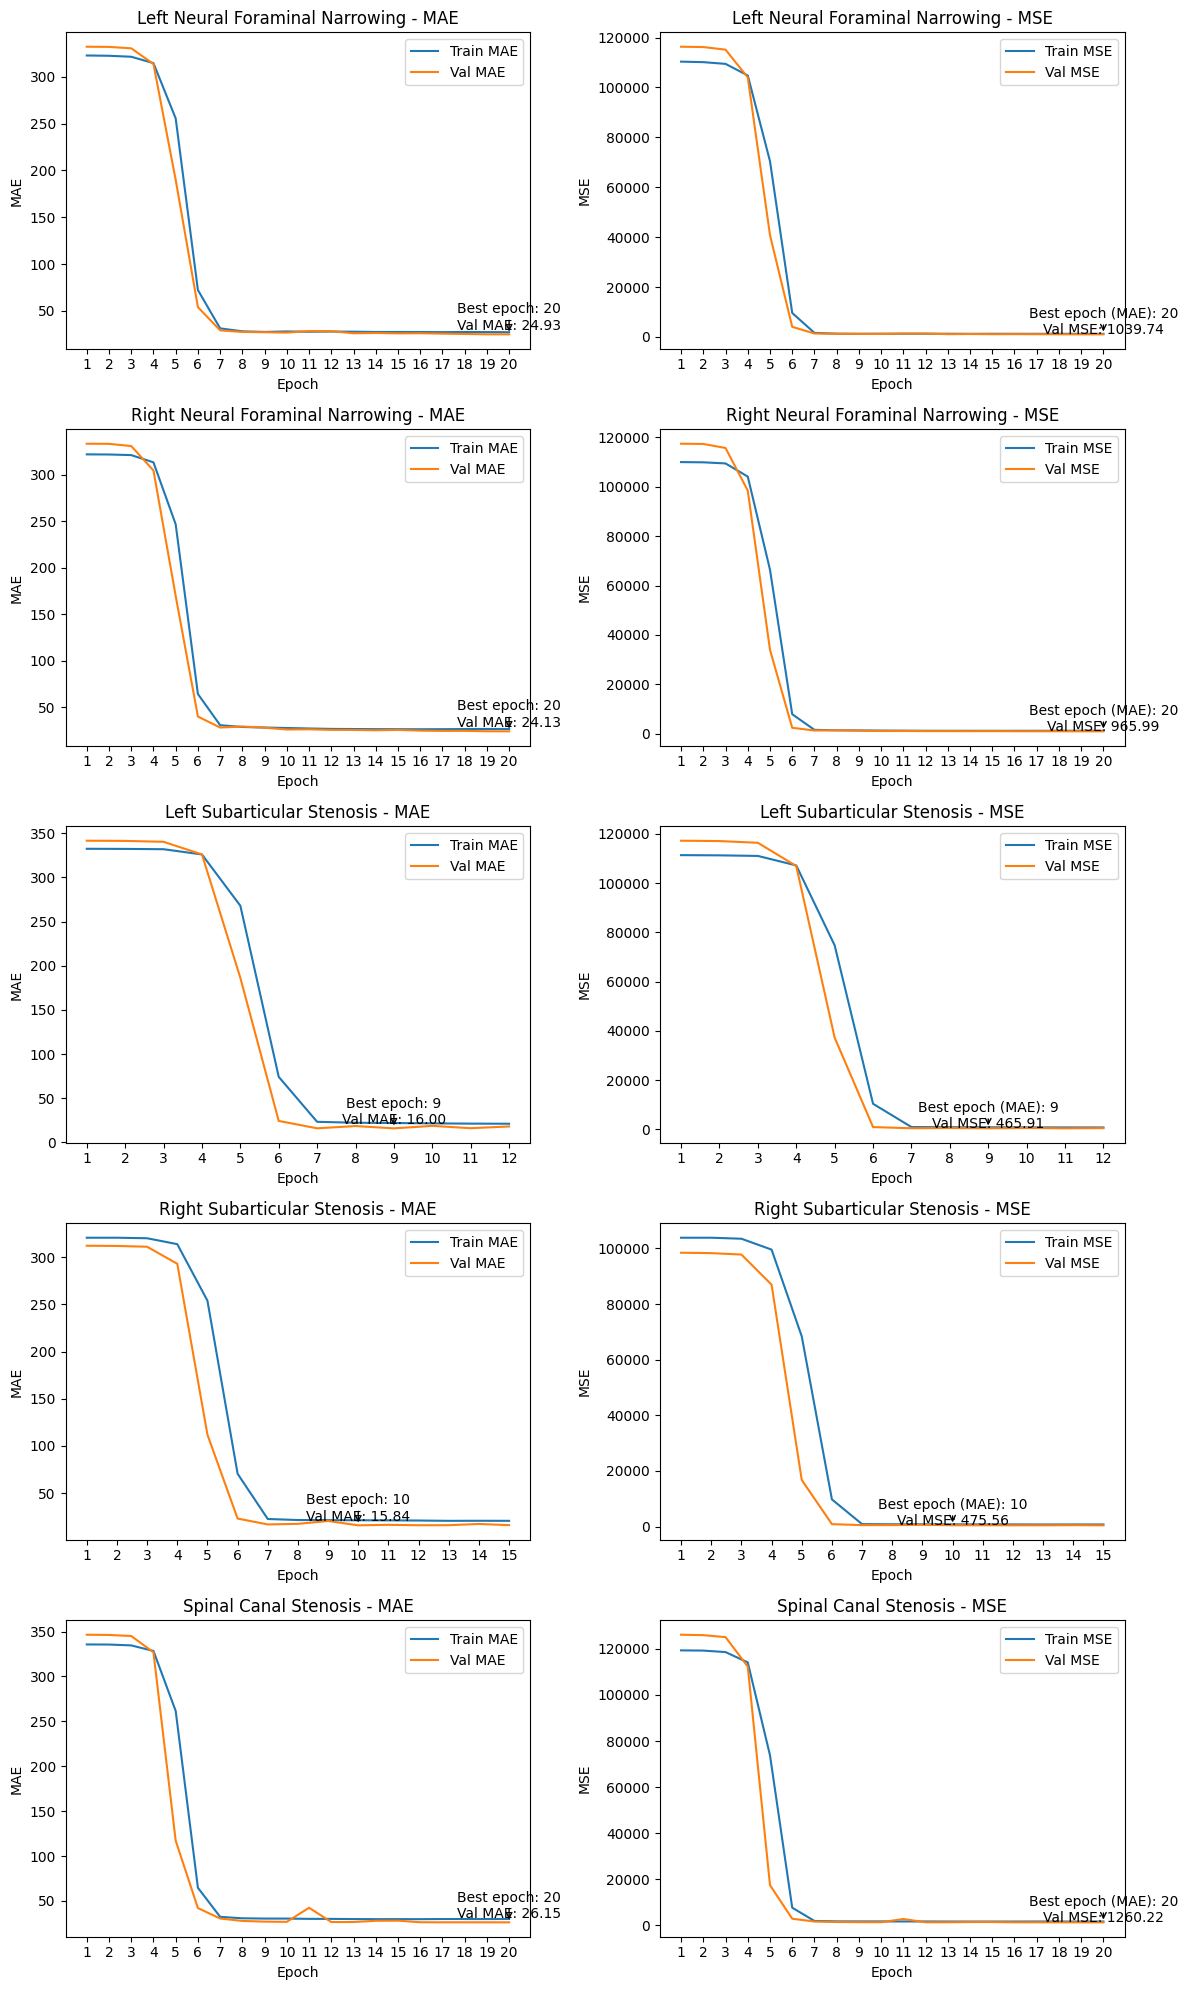

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------
# 1) Data for each condition (MAE & MSE) - extracted directly from your logs
# ------------------------------------------------------------------------

# A) Left Neural Foraminal Narrowing (LNFN): 20 epochs
lnfn_train_mae = [322.6438, 322.3278, 321.2895, 314.4811, 255.4710, 72.2090, 31.3092, 28.1345, 27.5175, 28.0158, 27.7341, 27.9115, 27.7435, 27.4461, 27.4763, 27.4106, 27.2894, 27.4506, 27.3372, 27.2126]
lnfn_val_mae = [332.0018, 331.8043, 330.2813, 313.5820, 189.8770, 53.9754, 29.1830, 27.4847, 27.1921, 26.7864, 28.4014, 28.3370, 26.0722, 26.4037, 25.9527, 26.0973, 25.6746, 25.3120, 24.9825, 24.9333]
lnfn_train_mse = [110352.7352, 110146.8920, 109453.4409, 104813.7095, 70432.1931, 9603.2936, 1630.6508, 1305.2137, 1260.4824, 1299.3469, 1285.1782, 1285.1483, 1278.0885, 1249.3491, 1256.2019, 1256.5011, 1247.7924, 1258.8588, 1249.1528, 1233.9406]
lnfn_val_mse = [116333.8777, 116199.1362, 115151.2318, 104016.3590, 40822.5638, 4049.4493, 1371.6570, 1248.4273, 1222.3475, 1186.3767, 1359.5310, 1353.8095, 1109.0612, 1161.2819, 1089.4224, 1118.0302, 1086.2442, 1065.1123, 1042.5574, 1039.7389]

# B) Right Neural Foraminal Narrowing (RNFN): 20 epochs
rnfn_train_mae = [322.0697, 321.9376, 321.2900, 313.4817, 246.8362, 64.2944, 30.7268, 28.8012, 28.2259, 27.7257, 27.1969, 26.7448, 26.6121, 26.4843, 26.4262, 26.3747, 26.4491, 26.5864, 26.6498, 26.6514]
rnfn_val_mae = [333.5306, 333.3922, 331.0225, 304.7546, 169.7888, 40.0279, 28.2296, 29.3300, 28.0276, 26.1216, 26.2897, 25.6919, 25.6248, 25.2544, 25.6470, 24.8729, 24.5927, 24.6469, 24.2266, 24.1262]
rnfn_train_mse = [109952.6785, 109863.7273, 109414.5385, 104082.7946, 66387.5109, 7890.3223, 1572.4273, 1381.5356, 1329.9897, 1278.5124, 1238.7390, 1197.8405, 1191.6216, 1183.7691, 1178.8603, 1179.9728, 1186.1829, 1198.3500, 1214.3676, 1200.3743]
rnfn_val_mse = [117395.2028, 117297.8526, 115669.4460, 98429.2829, 33950.9927, 2403.5842, 1301.8570, 1386.4131, 1270.3450, 1104.4068, 1119.3984, 1060.3198, 1056.6925, 1031.4364, 1059.8036, 1005.0743, 991.2709, 996.0589, 971.6278, 965.9857]

# C) Left Subarticular Stenosis (LSAS): 19 epochs (stopped early)
lsas_train_mae = [332.4286, 332.2952, 331.9445, 326.0110, 267.9803, 74.2794, 23.3826, 22.3237, 22.0139, 21.6320, 21.3443, 21.2083]
lsas_val_mae = [341.5672, 341.3572, 340.3270, 326.0647, 186.3462, 24.3711, 16.0485, 18.5776, 15.9999, 18.7870, 16.1711, 18.1197]
lsas_train_mse = [111402.6042, 111315.0472, 111079.5655, 107220.8777, 74765.3726, 10421.9735, 973.5375, 911.2716, 886.5701, 853.5406, 833.3989, 820.1117]
lsas_val_mse = [117257.9824, 117114.5364, 116414.5985, 106975.1907, 37297.2976, 962.0091, 488.1248, 581.0052, 465.9118, 583.5792, 452.4132, 541.6983]

# D) Right Subarticular Stenosis (RSAS): 16 epochs (stopped early)
rsas_train_mae = [320.7842, 320.7845, 320.2084, 313.9589, 254.0569, 70.5340, 22.5608, 21.4818, 21.3362, 21.2145, 21.1131, 20.9451, 20.6178, 20.6883, 20.6220]
rsas_val_mae = [312.2762, 312.0543, 311.2182, 293.1463, 112.0151, 23.0412, 16.7956, 17.4177, 20.4579, 15.8439, 16.3829, 15.9397, 15.9916, 17.2979, 16.0426]
rsas_train_mse = [103859.2555, 103859.4293, 103491.3508, 99585.5256, 68404.8473, 9774.1848, 880.3529, 829.9453, 817.8461, 804.7631, 801.3143, 783.9522, 756.4579, 770.9804, 758.5973]
rsas_val_mse = [98459.3271, 98320.5273, 97803.2918, 86965.8430, 16754.3006, 878.3604, 524.2083, 534.1075, 652.5519, 475.5573, 478.6207, 452.2768, 454.2933, 503.6621, 448.5046]

# E) Spinal Canal Stenosis (SCS): 20 epochs
scs_train_mae = [335.6493, 335.5187, 334.5747, 328.4002, 261.6075, 64.6351, 32.2708, 30.6744, 30.3470, 30.3331, 30.0246, 29.9962, 29.8131, 29.6911, 29.7276, 29.6907, 29.8388, 29.8372, 29.7962, 29.8869]
scs_val_mae = [346.4759, 346.2122, 345.0484, 326.8821, 117.1112, 42.0493, 30.4185, 27.7018, 26.9535, 26.7270, 42.3897, 26.4918, 26.5083, 27.8731, 28.0084, 26.2481, 26.1965, 26.1977, 26.1772, 26.1513]
scs_train_mse = [119358.2252, 119268.0722, 118617.1426, 114129.4066, 73799.0531, 7618.6661, 1859.5648, 1681.3001, 1664.2713, 1664.5843, 1642.1662, 1641.4807, 1612.9888, 1604.7857, 1609.8230, 1603.4501, 1632.6010, 1615.4050, 1598.7807, 1622.6874]
scs_val_mse = [126159.1099, 125966.0072, 125117.6556, 112307.9352, 17397.1197, 2824.2641, 1614.7702, 1404.0469, 1337.1918, 1313.5068, 2695.3032, 1285.5428, 1288.1520, 1382.3515, 1391.5829, 1265.7118, 1263.3468, 1262.5731, 1260.6776, 1260.2198]

# ------------------------------------------------------------------------
# 2) UTILITY: Function to plot a single condition's (MAE, MSE) subplots
# ------------------------------------------------------------------------
def plot_regression(ax_mae, ax_mse,
                    train_mae, val_mae,
                    train_mse, val_mse,
                    title_str):
    """
    ax_mae, ax_mse : matplotlib Axes objects for the MAE and MSE subplots
    train_mae, val_mae, train_mse, val_mse : lists of metric values
    title_str : label/title for this condition's row
    """

    epochs = np.arange(1, len(train_mae) + 1)

    # ---- MAE subplot ----
    ax_mae.plot(epochs, train_mae, label='Train MAE')
    ax_mae.plot(epochs, val_mae, label='Val MAE')
    ax_mae.set_title(f'{title_str} - MAE')
    ax_mae.set_xlabel('Epoch')
    ax_mae.set_ylabel('MAE')
    ax_mae.set_xticks(epochs)
    ax_mae.legend(loc='best')

    # Find best epoch (lowest val_mae)
    best_epoch_idx = np.argmin(val_mae)
    best_epoch_num = best_epoch_idx + 1
    best_val_mae = val_mae[best_epoch_idx]

    # Annotate on MAE subplot
    mae_text = f'Best epoch: {best_epoch_num}\nVal MAE: {best_val_mae:.2f}'
    ax_mae.annotate(
        mae_text,
        xy=(best_epoch_num, best_val_mae),
        xytext=(best_epoch_num, best_val_mae + 5),
        arrowprops=dict(arrowstyle='->', color='black'),
        ha='center'
    )

    # ---- MSE subplot ----
    ax_mse.plot(epochs, train_mse, label='Train MSE')
    ax_mse.plot(epochs, val_mse, label='Val MSE')
    ax_mse.set_title(f'{title_str} - MSE')
    ax_mse.set_xlabel('Epoch')
    ax_mse.set_ylabel('MSE')
    ax_mse.set_xticks(epochs)
    ax_mse.legend(loc='best')

    # MSE at that same best epoch
    best_val_mse = val_mse[best_epoch_idx]
    mse_text = (f'Best epoch (MAE): {best_epoch_num}\n'
                f'Val MSE: {best_val_mse:.2f}')
    ax_mse.annotate(
        mse_text,
        xy=(best_epoch_num, best_val_mse),
        xytext=(best_epoch_num, best_val_mse + 5),
        arrowprops=dict(arrowstyle='->', color='black'),
        ha='center'
    )


# ------------------------------------------------------------------------
# 3) MAIN PLOTTING (5 rows × 2 columns)
# ------------------------------------------------------------------------
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))

# Row 1: Left Neural Foraminal Narrowing
plot_regression(
    axes[0, 0],
    axes[0, 1],
    lnfn_train_mae,
    lnfn_val_mae,
    lnfn_train_mse,
    lnfn_val_mse,
    "Left Neural Foraminal Narrowing"
)

# Row 2: Right Neural Foraminal Narrowing
plot_regression(
    axes[1, 0],
    axes[1, 1],
    rnfn_train_mae,
    rnfn_val_mae,
    rnfn_train_mse,
    rnfn_val_mse,
    "Right Neural Foraminal Narrowing"
)

# Row 3: Left Subarticular Stenosis
plot_regression(
    axes[2, 0],
    axes[2, 1],
    lsas_train_mae,
    lsas_val_mae,
    lsas_train_mse,
    lsas_val_mse,
    "Left Subarticular Stenosis"
)

# Row 4: Right Subarticular Stenosis
plot_regression(
    axes[3, 0],
    axes[3, 1],
    rsas_train_mae,
    rsas_val_mae,
    rsas_train_mse,
    rsas_val_mse,
    "Right Subarticular Stenosis"
)

# Row 5: Spinal Canal Stenosis
plot_regression(
    axes[4, 0],
    axes[4, 1],
    scs_train_mae,
    scs_val_mae,
    scs_train_mse,
    scs_val_mse,
    "Spinal Canal Stenosis"
)

plt.tight_layout()
plt.show()


#YOLOv8m

In [ ]:
for desc, model in models.items():
    print(f"Training model for {desc}")

    train_model(model,
                trainloaders=dataloaders[desc]["train"],
                vallocoaders=dataloaders[desc]["val"],
                len_train=lengths[desc]["train"],
                len_val=lengths[desc]["val"],
                optimizer=optimizers[desc])


Training model for Sagittal T1 Left


100%|██████████| 50/50 [20:27<00:00, 24.55s/batch]


Level 1 - Train Loss: 249.0038


100%|██████████| 50/50 [03:42<00:00,  4.45s/batch]


Level 2 - Train Loss: 282.8654


100%|██████████| 50/50 [03:32<00:00,  4.25s/batch]


Level 3 - Train Loss: 317.8079


100%|██████████| 50/50 [03:36<00:00,  4.34s/batch]


Level 4 - Train Loss: 351.8244


100%|██████████| 50/50 [03:29<00:00,  4.18s/batch]

Level 5 - Train Loss: 383.6912


Level 1 - Val Loss: 275.7335
Level 2 - Val Loss: 300.9297
Level 3 - Val Loss: 328.9528
Level 4 - Val Loss: 358.7825
Level 5 - Val Loss: 393.7195
Epoch 1:
Train Loss: 317.0385, Train MAE: 317.5643, Train MSE: 107109.7050
Val Loss: 331.6236, Val MAE: 331.7846, Val MSE: 116177.4414



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 248.3248


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 282.0138


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 318.0554


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 350.9102


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 382.0049


Level 1 - Val Loss: 274.0146
Level 2 - Val Loss: 299.9366
Level 3 - Val Loss: 327.4544
Level 4 - Val Loss: 354.6447
Level 5 - Val Loss: 387.7544
Epoch 2:
Train Loss: 316.2618, Train MAE: 316.8649, Train MSE: 106660.7583
Val Loss: 328.7610, Val MAE: 329.1286, Val MSE: 114446.8058



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 246.0783


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 279.9772


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 316.3657


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 349.2643


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 380.0485


Level 1 - Val Loss: 272.4657
Level 2 - Val Loss: 297.6739
Level 3 - Val Loss: 325.3818
Level 4 - Val Loss: 354.5898
Level 5 - Val Loss: 389.4868
Epoch 3:
Train Loss: 314.3468, Train MAE: 314.9374, Train MSE: 105425.9764
Val Loss: 327.9196, Val MAE: 328.0798, Val MSE: 113724.3561



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 243.1192


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 274.9814


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 310.5260


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 340.6965


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 372.7578


Level 1 - Val Loss: 160.6283
Level 2 - Val Loss: 157.1955
Level 3 - Val Loss: 183.5330
Level 4 - Val Loss: 200.9461
Level 5 - Val Loss: 182.6202
Epoch 4:
Train Loss: 308.4162, Train MAE: 309.1440, Train MSE: 101766.2319
Val Loss: 176.9846, Val MAE: 176.0331, Val MSE: 44735.6059



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 228.0324


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 2 - Train Loss: 259.8445


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 295.1407


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 320.3218


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 351.9142


Level 1 - Val Loss: 261.0514
Level 2 - Val Loss: 284.1562
Level 3 - Val Loss: 312.2891
Level 4 - Val Loss: 340.1371
Level 5 - Val Loss: 375.2593
Epoch 5:
Train Loss: 291.0507, Train MAE: 291.8049, Train MSE: 91596.8109
Val Loss: 314.5786, Val MAE: 314.7384, Val MSE: 105112.1076



100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 1 - Train Loss: 198.9531


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 224.3686


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 261.8175


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 281.5214


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 313.9777


Level 1 - Val Loss: 211.3377
Level 2 - Val Loss: 228.3460
Level 3 - Val Loss: 260.2709
Level 4 - Val Loss: 285.8839
Level 5 - Val Loss: 323.0109
Epoch 6:
Train Loss: 256.1277, Train MAE: 257.0152, Train MSE: 73488.1728
Val Loss: 261.7699, Val MAE: 261.9301, Val MSE: 74775.3232



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 152.0135


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 170.8083


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 215.8217


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 223.7860


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]

Level 5 - Train Loss: 262.9153


Level 1 - Val Loss: 154.0298
Level 2 - Val Loss: 164.6777
Level 3 - Val Loss: 205.3919
Level 4 - Val Loss: 225.0196
Level 5 - Val Loss: 266.4404
Epoch 7:
Train Loss: 205.0690, Train MAE: 205.9838, Train MSE: 50274.5617
Val Loss: 203.1119, Val MAE: 203.0358, Val MSE: 48005.3579



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 102.3068


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 112.8384


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 161.1787


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 184.9389


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 222.7834


Level 1 - Val Loss: 106.3579
Level 2 - Val Loss: 106.7136
Level 3 - Val Loss: 141.2007
Level 4 - Val Loss: 146.8557
Level 5 - Val Loss: 190.3091
Epoch 8:
Train Loss: 156.8092, Train MAE: 157.6104, Train MSE: 32331.4007
Val Loss: 138.2874, Val MAE: 137.8942, Val MSE: 25276.0051



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 76.7238


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 60.2953


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 107.6361


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 132.1708


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 169.8767


Level 1 - Val Loss: 93.1175
Level 2 - Val Loss: 72.5932
Level 3 - Val Loss: 97.0382
Level 4 - Val Loss: 105.1085
Level 5 - Val Loss: 150.2668
Epoch 9:
Train Loss: 109.3405, Train MAE: 109.9685, Train MSE: 17867.4386
Val Loss: 103.6248, Val MAE: 104.4127, Val MSE: 15326.9850



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 58.2764


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 46.0901


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 59.5259


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 4 - Train Loss: 83.1013


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 123.9391


Level 1 - Val Loss: 63.2212
Level 2 - Val Loss: 46.4251
Level 3 - Val Loss: 44.4289
Level 4 - Val Loss: 61.6722
Level 5 - Val Loss: 100.0708
Epoch 10:
Train Loss: 74.1866, Train MAE: 74.5798, Train MSE: 9776.8643
Val Loss: 63.1636, Val MAE: 63.7173, Val MSE: 6973.7958



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 48.1318


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 2 - Train Loss: 39.5183


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 38.4281


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 56.5771


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 92.8403


Level 1 - Val Loss: 52.5784
Level 2 - Val Loss: 38.3849
Level 3 - Val Loss: 33.2449
Level 4 - Val Loss: 43.4573
Level 5 - Val Loss: 77.6772
Epoch 11:
Train Loss: 55.0991, Train MAE: 55.6358, Train MSE: 6057.8764
Val Loss: 49.0686, Val MAE: 48.8658, Val MSE: 4629.8709



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 46.7574


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 42.4245


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 38.7451


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 45.6977


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 76.8396


Level 1 - Val Loss: 51.1690
Level 2 - Val Loss: 38.1775
Level 3 - Val Loss: 42.8176
Level 4 - Val Loss: 37.4455
Level 5 - Val Loss: 59.2936
Epoch 12:
Train Loss: 50.0929, Train MAE: 50.4495, Train MSE: 4937.5677
Val Loss: 45.7806, Val MAE: 46.1367, Val MSE: 3977.7643



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 46.6908


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 40.4383


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 35.9327


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 42.2801


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 64.3191


Level 1 - Val Loss: 47.9651
Level 2 - Val Loss: 43.5519
Level 3 - Val Loss: 33.9956
Level 4 - Val Loss: 44.1170
Level 5 - Val Loss: 60.3447
Epoch 13:
Train Loss: 45.9322, Train MAE: 46.3039, Train MSE: 4097.2137
Val Loss: 45.9948, Val MAE: 46.6382, Val MSE: 3758.1773



100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 1 - Train Loss: 44.0718


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 39.1947


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 36.1450


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 37.6489


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 52.9611


Level 1 - Val Loss: 43.5425
Level 2 - Val Loss: 36.9178
Level 3 - Val Loss: 30.9141
Level 4 - Val Loss: 35.1292
Level 5 - Val Loss: 50.1347
Epoch 14:
Train Loss: 42.0043, Train MAE: 42.5982, Train MSE: 3517.2528
Val Loss: 39.3277, Val MAE: 39.1517, Val MSE: 2801.7661



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 42.6877


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 2 - Train Loss: 36.6919


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 36.2956


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 4 - Train Loss: 37.6717


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 51.9934


Level 1 - Val Loss: 45.9639
Level 2 - Val Loss: 36.3328
Level 3 - Val Loss: 37.1960
Level 4 - Val Loss: 35.0649
Level 5 - Val Loss: 41.7673
Epoch 15:
Train Loss: 41.0681, Train MAE: 41.2753, Train MSE: 3266.4077
Val Loss: 39.2650, Val MAE: 39.7620, Val MSE: 2793.0469



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 42.1934


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 2 - Train Loss: 37.3304


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 35.1013


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 36.2010


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 46.4049


Level 1 - Val Loss: 44.7766
Level 2 - Val Loss: 36.7584
Level 3 - Val Loss: 32.2277
Level 4 - Val Loss: 34.0461
Level 5 - Val Loss: 41.3642
Epoch 16:
Train Loss: 39.4462, Train MAE: 39.9483, Train MSE: 3037.4931
Val Loss: 37.8346, Val MAE: 38.2726, Val MSE: 3044.5753



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 43.4780


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 2 - Train Loss: 35.8487


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 3 - Train Loss: 32.5458


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 35.8696


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 43.9901


Level 1 - Val Loss: 44.2325
Level 2 - Val Loss: 35.5928
Level 3 - Val Loss: 30.5575
Level 4 - Val Loss: 31.5355
Level 5 - Val Loss: 41.2837
Epoch 17:
Train Loss: 38.3464, Train MAE: 38.7215, Train MSE: 2810.9729
Val Loss: 36.6404, Val MAE: 36.8994, Val MSE: 2520.0660



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 41.6575


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 2 - Train Loss: 37.3074


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 35.2994


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 35.8344


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 42.7885


Level 1 - Val Loss: 43.2535
Level 2 - Val Loss: 35.3382
Level 3 - Val Loss: 30.5095
Level 4 - Val Loss: 32.9029
Level 5 - Val Loss: 42.9773
Epoch 18:
Train Loss: 38.5774, Train MAE: 38.8937, Train MSE: 2863.9761
Val Loss: 36.9963, Val MAE: 37.3741, Val MSE: 2542.0842



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 41.4457


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 36.4534


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 35.5895


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 34.0455


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]

Level 5 - Train Loss: 41.0592


Level 1 - Val Loss: 42.2890
Level 2 - Val Loss: 34.0131
Level 3 - Val Loss: 29.6496
Level 4 - Val Loss: 30.3718
Level 5 - Val Loss: 37.6645
Epoch 19:
Train Loss: 37.7187, Train MAE: 38.2510, Train MSE: 2703.5170
Val Loss: 34.7976, Val MAE: 35.2796, Val MSE: 2329.4029



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 42.4353


100%|██████████| 50/50 [00:33<00:00,  1.51batch/s]


Level 2 - Train Loss: 35.4469


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 34.0497


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 34.5361


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 41.9178


Level 1 - Val Loss: 41.6286
Level 2 - Val Loss: 32.9971
Level 3 - Val Loss: 29.5292
Level 4 - Val Loss: 30.4606
Level 5 - Val Loss: 37.7889
Epoch 20:
Train Loss: 37.6772, Train MAE: 38.0889, Train MSE: 2682.4887
Val Loss: 34.4809, Val MAE: 34.7532, Val MSE: 2188.1574

Training model for Sagittal T1 Right


100%|██████████| 50/50 [12:24<00:00, 14.89s/batch]


Level 1 - Train Loss: 248.4259


100%|██████████| 50/50 [03:26<00:00,  4.13s/batch]


Level 2 - Train Loss: 283.9239


100%|██████████| 50/50 [03:56<00:00,  4.74s/batch]


Level 3 - Train Loss: 317.6688


100%|██████████| 50/50 [03:52<00:00,  4.64s/batch]


Level 4 - Train Loss: 352.2946


100%|██████████| 50/50 [04:48<00:00,  5.78s/batch]

Level 5 - Train Loss: 384.1984


Level 1 - Val Loss: 275.7064
Level 2 - Val Loss: 301.1990
Level 3 - Val Loss: 329.9253
Level 4 - Val Loss: 360.3791
Level 5 - Val Loss: 396.5551
Epoch 1:
Train Loss: 317.3023, Train MAE: 317.9453, Train MSE: 107313.3329
Val Loss: 332.7530, Val MAE: 333.3435, Val MSE: 117267.1040



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 249.2399


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 2 - Train Loss: 282.7892


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 318.2900


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 350.9329


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]

Level 5 - Train Loss: 384.0785


Level 1 - Val Loss: 276.4463
Level 2 - Val Loss: 272.4865
Level 3 - Val Loss: 292.1101
Level 4 - Val Loss: 310.3640
Level 5 - Val Loss: 334.7873
Epoch 2:
Train Loss: 317.0661, Train MAE: 317.5944, Train MSE: 107085.5266
Val Loss: 297.2388, Val MAE: 298.2962, Val MSE: 98429.0476



100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 1 - Train Loss: 247.5096


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 2 - Train Loss: 281.7747


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 3 - Train Loss: 315.8685


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 349.6720


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]

Level 5 - Train Loss: 381.9190


Level 1 - Val Loss: 252.3201
Level 2 - Val Loss: 245.4082
Level 3 - Val Loss: 257.7771
Level 4 - Val Loss: 269.5620
Level 5 - Val Loss: 301.2959
Epoch 3:
Train Loss: 315.3488, Train MAE: 315.8488, Train MSE: 105965.0147
Val Loss: 265.2727, Val MAE: 264.9857, Val MSE: 83344.1144



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 242.7185


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 2 - Train Loss: 277.0542


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 3 - Train Loss: 309.1692


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 4 - Train Loss: 340.2931


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 376.0096


Level 1 - Val Loss: 247.4347
Level 2 - Val Loss: 258.4271
Level 3 - Val Loss: 282.1284
Level 4 - Val Loss: 308.6629
Level 5 - Val Loss: 339.8422
Epoch 4:
Train Loss: 309.0489, Train MAE: 309.6351, Train MSE: 102064.1392
Val Loss: 287.2990, Val MAE: 287.4066, Val MSE: 94474.5599



100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 1 - Train Loss: 228.2874


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 2 - Train Loss: 259.0697


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 290.6167


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 317.3043


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]

Level 5 - Train Loss: 355.6346


Level 1 - Val Loss: 245.3765
Level 2 - Val Loss: 267.4691
Level 3 - Val Loss: 296.8826
Level 4 - Val Loss: 318.7611
Level 5 - Val Loss: 366.3273
Epoch 5:
Train Loss: 290.1825, Train MAE: 291.0063, Train MSE: 91433.6734
Val Loss: 298.9633, Val MAE: 299.4799, Val MSE: 95902.8604



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 195.8137


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 221.5946


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 252.0264


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 276.5360


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 316.0129


Level 1 - Val Loss: 208.8217
Level 2 - Val Loss: 203.0469
Level 3 - Val Loss: 211.3827
Level 4 - Val Loss: 242.8730
Level 5 - Val Loss: 262.6725
Epoch 6:
Train Loss: 252.3967, Train MAE: 253.3403, Train MSE: 72017.7717
Val Loss: 225.7594, Val MAE: 225.2689, Val MSE: 60069.4293



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 144.7506


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 171.9898


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 202.1525


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 218.3702


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 263.7754


Level 1 - Val Loss: 118.4622
Level 2 - Val Loss: 90.1345
Level 3 - Val Loss: 82.1412
Level 4 - Val Loss: 93.8289
Level 5 - Val Loss: 112.2638
Epoch 7:
Train Loss: 200.2077, Train MAE: 200.6820, Train MSE: 49014.5816
Val Loss: 99.3661, Val MAE: 97.0553, Val MSE: 16147.6149



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 93.0194


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 112.2611


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 158.1305


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 171.7228


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 225.0148


Level 1 - Val Loss: 137.8451
Level 2 - Val Loss: 91.7679
Level 3 - Val Loss: 125.7895
Level 4 - Val Loss: 121.3921
Level 5 - Val Loss: 126.2439
Epoch 8:
Train Loss: 152.0297, Train MAE: 152.7410, Train MSE: 31650.5386
Val Loss: 120.6077, Val MAE: 121.9027, Val MSE: 20276.0807



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 73.0189


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 70.1633


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 104.3307


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 126.9626


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 201.6219


Level 1 - Val Loss: 84.2822
Level 2 - Val Loss: 67.9048
Level 3 - Val Loss: 94.7896
Level 4 - Val Loss: 113.1067
Level 5 - Val Loss: 222.2163
Epoch 9:
Train Loss: 115.2195, Train MAE: 115.8425, Train MSE: 20513.4971
Val Loss: 116.4599, Val MAE: 117.0411, Val MSE: 20230.1883



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 68.3579


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 58.4378


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 61.6502


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 79.2202


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 173.9103


Level 1 - Val Loss: 62.3586
Level 2 - Val Loss: 51.3873
Level 3 - Val Loss: 79.2508
Level 4 - Val Loss: 69.7402
Level 5 - Val Loss: 101.8463
Epoch 10:
Train Loss: 88.3153, Train MAE: 88.3765, Train MSE: 13745.3274
Val Loss: 72.9166, Val MAE: 72.9597, Val MSE: 9054.7287



100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 1 - Train Loss: 51.6890


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 45.5329


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 3 - Train Loss: 43.8524


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 49.1825


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 125.3715


Level 1 - Val Loss: 70.3122
Level 2 - Val Loss: 58.6277
Level 3 - Val Loss: 44.7939
Level 4 - Val Loss: 51.2987
Level 5 - Val Loss: 121.3870
Epoch 11:
Train Loss: 63.1257, Train MAE: 63.4010, Train MSE: 8181.8212
Val Loss: 69.2839, Val MAE: 70.0279, Val MSE: 8388.0376



100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 1 - Train Loss: 46.5539


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 43.6057


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 41.0188


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 45.3891


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 112.2316


Level 1 - Val Loss: 62.8450
Level 2 - Val Loss: 65.3622
Level 3 - Val Loss: 49.8918
Level 4 - Val Loss: 50.6994
Level 5 - Val Loss: 89.7230
Epoch 12:
Train Loss: 57.7598, Train MAE: 58.0434, Train MSE: 6932.4218
Val Loss: 63.7043, Val MAE: 64.3967, Val MSE: 6866.5195



100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 1 - Train Loss: 44.9144


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 39.9863


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 39.1432


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 39.1730


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 91.4494


Level 1 - Val Loss: 46.8551
Level 2 - Val Loss: 44.5546
Level 3 - Val Loss: 38.0331
Level 4 - Val Loss: 37.8963
Level 5 - Val Loss: 69.4586
Epoch 13:
Train Loss: 50.9333, Train MAE: 51.1334, Train MSE: 5405.1664
Val Loss: 47.3595, Val MAE: 47.9251, Val MSE: 4283.1501



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 41.8681


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 2 - Train Loss: 37.0678


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 37.1858


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 39.4879


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 78.8494


Level 1 - Val Loss: 55.1499
Level 2 - Val Loss: 56.1569
Level 3 - Val Loss: 48.4835
Level 4 - Val Loss: 47.2102
Level 5 - Val Loss: 70.7468
Epoch 14:
Train Loss: 46.8918, Train MAE: 47.1342, Train MSE: 4431.4209
Val Loss: 55.5495, Val MAE: 55.6949, Val MSE: 5781.5599



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 45.1809


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 37.1650


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 36.1467


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 39.5370


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 72.7986


Level 1 - Val Loss: 46.5425
Level 2 - Val Loss: 41.1114
Level 3 - Val Loss: 37.6304
Level 4 - Val Loss: 35.1669
Level 5 - Val Loss: 56.8912
Epoch 15:
Train Loss: 46.1656, Train MAE: 46.2081, Train MSE: 4212.1049
Val Loss: 43.4685, Val MAE: 43.7749, Val MSE: 3331.3218



100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 1 - Train Loss: 43.6408


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 37.4594


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 35.7742


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 39.7506


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 69.0299


Level 1 - Val Loss: 44.4332
Level 2 - Val Loss: 39.7491
Level 3 - Val Loss: 33.2332
Level 4 - Val Loss: 34.4471
Level 5 - Val Loss: 54.1355
Epoch 16:
Train Loss: 45.1310, Train MAE: 45.0678, Train MSE: 3927.1181
Val Loss: 41.1996, Val MAE: 42.1551, Val MSE: 3320.3302



100%|██████████| 50/50 [00:33<00:00,  1.51batch/s]


Level 1 - Train Loss: 40.7901


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 37.6563


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 34.2256


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 37.4341


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 63.8034


Level 1 - Val Loss: 41.7490
Level 2 - Val Loss: 36.0626
Level 3 - Val Loss: 30.8904
Level 4 - Val Loss: 31.9362
Level 5 - Val Loss: 51.2966
Epoch 17:
Train Loss: 42.7819, Train MAE: 43.1971, Train MSE: 3552.8416
Val Loss: 38.3870, Val MAE: 39.0031, Val MSE: 2711.6391



100%|██████████| 50/50 [00:33<00:00,  1.51batch/s]


Level 1 - Train Loss: 41.2866


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 36.5694


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 35.6084


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 37.7305


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 63.8302


Level 1 - Val Loss: 42.3669
Level 2 - Val Loss: 37.9306
Level 3 - Val Loss: 32.0067
Level 4 - Val Loss: 34.4106
Level 5 - Val Loss: 53.4598
Epoch 18:
Train Loss: 43.0050, Train MAE: 42.9120, Train MSE: 3471.9765
Val Loss: 40.0349, Val MAE: 41.0681, Val MSE: 3376.1625



100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 1 - Train Loss: 40.8494


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 36.8592


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 34.1046


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 34.3767


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 63.0542


Level 1 - Val Loss: 41.5556
Level 2 - Val Loss: 36.4437
Level 3 - Val Loss: 31.6984
Level 4 - Val Loss: 34.2947
Level 5 - Val Loss: 51.6688
Epoch 19:
Train Loss: 41.8488, Train MAE: 42.3038, Train MSE: 3355.0182
Val Loss: 39.1322, Val MAE: 40.2727, Val MSE: 3206.5131



100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 1 - Train Loss: 39.3767


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 38.3482


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 3 - Train Loss: 33.7326


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 36.9397


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 61.0877


Level 1 - Val Loss: 40.9719
Level 2 - Val Loss: 32.8432
Level 3 - Val Loss: 31.0738
Level 4 - Val Loss: 34.7490
Level 5 - Val Loss: 52.1164
Epoch 20:
Train Loss: 41.8970, Train MAE: 42.2859, Train MSE: 3352.7488
Val Loss: 38.3509, Val MAE: 39.4124, Val MSE: 2930.6320

Training model for Axial T2 Left


100%|██████████| 46/46 [18:23<00:00, 23.99s/batch]


Level 1 - Train Loss: 332.0600


100%|██████████| 48/48 [13:18<00:00, 16.64s/batch]


Level 2 - Train Loss: 327.3878


100%|██████████| 50/50 [13:07<00:00, 15.76s/batch]


Level 3 - Train Loss: 324.4420


100%|██████████| 50/50 [12:19<00:00, 14.79s/batch]


Level 4 - Train Loss: 323.0162


100%|██████████| 50/50 [12:16<00:00, 14.74s/batch]

Level 5 - Train Loss: 323.5967


Level 1 - Val Loss: 348.1700
Level 2 - Val Loss: 343.1846
Level 3 - Val Loss: 338.9483
Level 4 - Val Loss: 336.0247
Level 5 - Val Loss: 337.4373
Epoch 1:
Train Loss: 326.1005, Train MAE: 326.4615, Train MSE: 107588.3908
Val Loss: 340.7530, Val MAE: 341.3429, Val MSE: 117105.1480



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 332.0467


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 327.9158


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 3 - Train Loss: 323.9275


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 322.7772


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 322.7730


Level 1 - Val Loss: 347.8567
Level 2 - Val Loss: 343.0800
Level 3 - Val Loss: 337.7544
Level 4 - Val Loss: 334.3479
Level 5 - Val Loss: 334.7510
Epoch 2:
Train Loss: 325.8880, Train MAE: 326.3080, Train MSE: 107483.2650
Val Loss: 339.5580, Val MAE: 340.1201, Val MSE: 116282.8585



100%|██████████| 46/46 [00:30<00:00,  1.51batch/s]


Level 1 - Train Loss: 330.4628


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 326.3473


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 322.7223


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 320.3309


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]

Level 5 - Train Loss: 320.5677


Level 1 - Val Loss: 345.0862
Level 2 - Val Loss: 340.2260
Level 3 - Val Loss: 332.7132
Level 4 - Val Loss: 330.3055
Level 5 - Val Loss: 328.8989
Epoch 3:
Train Loss: 324.0862, Train MAE: 324.4235, Train MSE: 106262.9831
Val Loss: 335.4460, Val MAE: 335.9628, Val MSE: 113587.5903



100%|██████████| 46/46 [00:30<00:00,  1.51batch/s]


Level 1 - Train Loss: 325.5116


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 321.2085


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 316.1934


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 314.1717


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]

Level 5 - Train Loss: 314.0031


Level 1 - Val Loss: 505.6008
Level 2 - Val Loss: 593.0114
Level 3 - Val Loss: 3004.0442
Level 4 - Val Loss: 2007.1549
Level 5 - Val Loss: 3824.3595
Epoch 4:
Train Loss: 318.2176, Train MAE: 318.5900, Train MSE: 102556.2673
Val Loss: 1986.8342, Val MAE: 2032.6693, Val MSE: 13193289.3363



100%|██████████| 46/46 [00:30<00:00,  1.53batch/s]


Level 1 - Train Loss: 312.6973


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 306.9191


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 298.7206


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 295.5624


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]

Level 5 - Train Loss: 291.4827


Level 1 - Val Loss: 321.2553
Level 2 - Val Loss: 315.9755
Level 3 - Val Loss: 270.8860
Level 4 - Val Loss: 286.3752
Level 5 - Val Loss: 237.4900
Epoch 5:
Train Loss: 301.0764, Train MAE: 301.6061, Train MSE: 92474.7447
Val Loss: 286.3964, Val MAE: 286.7189, Val MSE: 84507.9548



100%|██████████| 46/46 [00:30<00:00,  1.53batch/s]


Level 1 - Train Loss: 285.0954


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 279.5842


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 3 - Train Loss: 270.2351


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 266.8247


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 262.9859


Level 1 - Val Loss: 288.8267
Level 2 - Val Loss: 282.5809
Level 3 - Val Loss: 288.0740
Level 4 - Val Loss: 278.0464
Level 5 - Val Loss: 284.9893
Epoch 6:
Train Loss: 272.9450, Train MAE: 273.4475, Train MSE: 77137.4946
Val Loss: 284.5035, Val MAE: 285.3543, Val MSE: 82227.3584



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 240.3148


100%|██████████| 48/48 [00:31<00:00,  1.54batch/s]


Level 2 - Train Loss: 229.0916


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 222.1622


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 214.7212


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]

Level 5 - Train Loss: 216.0966


Level 1 - Val Loss: 226.1965
Level 2 - Val Loss: 216.7318
Level 3 - Val Loss: 234.4582
Level 4 - Val Loss: 217.0990
Level 5 - Val Loss: 238.2618
Epoch 7:
Train Loss: 224.4773, Train MAE: 225.0817, Train MSE: 54210.8464
Val Loss: 226.5495, Val MAE: 227.3571, Val MSE: 52321.8404



100%|██████████| 46/46 [00:30<00:00,  1.53batch/s]


Level 1 - Train Loss: 177.2815


100%|██████████| 48/48 [00:31<00:00,  1.54batch/s]


Level 2 - Train Loss: 164.8423


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 3 - Train Loss: 183.1758


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 166.2477


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]

Level 5 - Train Loss: 177.7820


Level 1 - Val Loss: 156.0593
Level 2 - Val Loss: 151.4939
Level 3 - Val Loss: 170.5364
Level 4 - Val Loss: 154.4508
Level 5 - Val Loss: 177.1412
Epoch 8:
Train Loss: 173.8659, Train MAE: 174.8132, Train MSE: 33845.3387
Val Loss: 161.9363, Val MAE: 162.6716, Val MSE: 28442.6010



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 111.6594


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 98.5466


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 3 - Train Loss: 136.1912


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 117.1089


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]

Level 5 - Train Loss: 137.4921


Level 1 - Val Loss: 134.2803
Level 2 - Val Loss: 156.8385
Level 3 - Val Loss: 140.7835
Level 4 - Val Loss: 129.1420
Level 5 - Val Loss: 135.0526
Epoch 9:
Train Loss: 120.1996, Train MAE: 121.2795, Train MSE: 17629.5070
Val Loss: 139.2194, Val MAE: 140.2154, Val MSE: 22877.0197



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 58.1873


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 47.0985


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 80.8372


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 66.3029


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]

Level 5 - Train Loss: 112.7841


Level 1 - Val Loss: 52.5516
Level 2 - Val Loss: 66.4199
Level 3 - Val Loss: 75.7154
Level 4 - Val Loss: 60.4765
Level 5 - Val Loss: 96.5275
Epoch 10:
Train Loss: 73.0420, Train MAE: 73.9634, Train MSE: 8500.0105
Val Loss: 70.3382, Val MAE: 71.8061, Val MSE: 7482.4331



100%|██████████| 46/46 [00:30<00:00,  1.53batch/s]


Level 1 - Train Loss: 37.2036


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 38.6397


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 3 - Train Loss: 46.8516


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 36.5669


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]

Level 5 - Train Loss: 65.7507


Level 1 - Val Loss: 39.3880
Level 2 - Val Loss: 40.3947
Level 3 - Val Loss: 29.5689
Level 4 - Val Loss: 29.7858
Level 5 - Val Loss: 49.4050
Epoch 11:
Train Loss: 45.0025, Train MAE: 45.0136, Train MSE: 3819.0309
Val Loss: 37.7085, Val MAE: 38.3869, Val MSE: 2651.5397



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 35.4228


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 34.0304


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 36.2888


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 31.1663


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]

Level 5 - Train Loss: 43.1520


Level 1 - Val Loss: 28.7503
Level 2 - Val Loss: 28.4565
Level 3 - Val Loss: 35.4532
Level 4 - Val Loss: 24.6978
Level 5 - Val Loss: 33.6991
Epoch 12:
Train Loss: 36.0121, Train MAE: 36.2346, Train MSE: 2796.2213
Val Loss: 30.2114, Val MAE: 30.9921, Val MSE: 1900.4634



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 33.1770


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 30.9111


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 3 - Train Loss: 30.2694


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 30.2847


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]

Level 5 - Train Loss: 34.3123


Level 1 - Val Loss: 29.4818
Level 2 - Val Loss: 28.7676
Level 3 - Val Loss: 28.3533
Level 4 - Val Loss: 23.1065
Level 5 - Val Loss: 33.2023
Epoch 13:
Train Loss: 31.7909, Train MAE: 31.6511, Train MSE: 2061.2653
Val Loss: 28.5823, Val MAE: 29.3204, Val MSE: 1641.7504



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 34.1875


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 36.6429


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 30.0471


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 27.6548


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]

Level 5 - Train Loss: 33.7038


Level 1 - Val Loss: 25.3083
Level 2 - Val Loss: 25.9783
Level 3 - Val Loss: 23.4626
Level 4 - Val Loss: 20.9354
Level 5 - Val Loss: 28.3704
Epoch 14:
Train Loss: 32.4472, Train MAE: 32.5623, Train MSE: 2135.4247
Val Loss: 24.8110, Val MAE: 25.3688, Val MSE: 1088.7507



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 30.7980


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 30.0053


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 27.0410


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 26.5497


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 31.3538


Level 1 - Val Loss: 28.1188
Level 2 - Val Loss: 27.9842
Level 3 - Val Loss: 25.7462
Level 4 - Val Loss: 23.7717
Level 5 - Val Loss: 31.0757
Epoch 15:
Train Loss: 29.1495, Train MAE: 29.2273, Train MSE: 1541.6972
Val Loss: 27.3393, Val MAE: 27.9787, Val MSE: 1254.3861



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 29.5143


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 28.3904


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 26.7840


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 26.0128


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 31.1179


Level 1 - Val Loss: 25.4045
Level 2 - Val Loss: 25.4883
Level 3 - Val Loss: 23.9803
Level 4 - Val Loss: 21.5395
Level 5 - Val Loss: 30.4408
Epoch 16:
Train Loss: 28.3639, Train MAE: 28.5421, Train MSE: 1434.5365
Val Loss: 25.3707, Val MAE: 25.9789, Val MSE: 1131.4816



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 29.3226


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 28.7075


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 25.8074


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 25.6292


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 29.4608


Level 1 - Val Loss: 26.2749
Level 2 - Val Loss: 26.9177
Level 3 - Val Loss: 25.9998
Level 4 - Val Loss: 23.3128
Level 5 - Val Loss: 30.1822
Epoch 17:
Train Loss: 27.7855, Train MAE: 27.8737, Train MSE: 1292.3218
Val Loss: 26.5375, Val MAE: 27.2437, Val MSE: 1434.6390



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 29.0420


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 26.8512


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 26.1662


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 25.1061


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 29.7912


Level 1 - Val Loss: 27.0970
Level 2 - Val Loss: 27.9682
Level 3 - Val Loss: 30.1106
Level 4 - Val Loss: 26.3467
Level 5 - Val Loss: 32.0476
Epoch 18:
Train Loss: 27.3913, Train MAE: 27.3900, Train MSE: 1227.1466
Val Loss: 28.7140, Val MAE: 29.3734, Val MSE: 2418.8231



100%|██████████| 46/46 [00:30<00:00,  1.53batch/s]


Level 1 - Train Loss: 28.3799


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 26.5262


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 24.8023


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 4 - Train Loss: 24.7182


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 30.3607


Level 1 - Val Loss: 27.0373
Level 2 - Val Loss: 29.1782
Level 3 - Val Loss: 32.7125
Level 4 - Val Loss: 29.3336
Level 5 - Val Loss: 35.2130
Epoch 19:
Train Loss: 26.9574, Train MAE: 26.9494, Train MSE: 1134.5617
Val Loss: 30.6949, Val MAE: 31.6300, Val MSE: 5306.0929

Early stopping triggered after 19 epochs

Training model for Axial T2 Right


100%|██████████| 46/46 [05:49<00:00,  7.61s/batch]


Level 1 - Train Loss: 332.3838


100%|██████████| 48/48 [05:07<00:00,  6.41s/batch]


Level 2 - Train Loss: 327.1936


100%|██████████| 50/50 [05:14<00:00,  6.29s/batch]


Level 3 - Train Loss: 323.2405


100%|██████████| 50/50 [05:21<00:00,  6.43s/batch]


Level 4 - Train Loss: 322.8247


100%|██████████| 50/50 [05:44<00:00,  6.90s/batch]

Level 5 - Train Loss: 322.5420


Level 1 - Val Loss: 317.2862
Level 2 - Val Loss: 313.4874
Level 3 - Val Loss: 310.8520
Level 4 - Val Loss: 308.4358
Level 5 - Val Loss: 307.4872
Epoch 1:
Train Loss: 325.6369, Train MAE: 325.9841, Train MSE: 107182.0280
Val Loss: 311.5097, Val MAE: 312.0573, Val MSE: 98325.6409



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 332.1196


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 326.5464


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 3 - Train Loss: 322.5187


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 321.6495


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]

Level 5 - Train Loss: 321.8613


Level 1 - Val Loss: 316.9670
Level 2 - Val Loss: 313.1282
Level 3 - Val Loss: 309.4249
Level 4 - Val Loss: 306.4930
Level 5 - Val Loss: 305.1903
Epoch 2:
Train Loss: 324.9391, Train MAE: 325.3178, Train MSE: 106751.7861
Val Loss: 310.2407, Val MAE: 310.7715, Val MSE: 97538.8449



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 330.6538


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 324.8624


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 3 - Train Loss: 321.5596


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 4 - Train Loss: 319.2498


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 319.2500


Level 1 - Val Loss: 241.6164
Level 2 - Val Loss: 1122.9718
Level 3 - Val Loss: 1890.7858
Level 4 - Val Loss: 1446.1770
Level 5 - Val Loss: 1552.6995
Epoch 3:
Train Loss: 323.1151, Train MAE: 323.4461, Train MSE: 105543.7818
Val Loss: 1250.8501, Val MAE: 1282.1242, Val MSE: 6091788.0209



100%|██████████| 46/46 [00:30<00:00,  1.53batch/s]


Level 1 - Train Loss: 326.9760


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 319.5939


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 315.0354


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 310.8875


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 310.3708


Level 1 - Val Loss: 307.3858
Level 2 - Val Loss: 299.4255
Level 3 - Val Loss: 290.1690
Level 4 - Val Loss: 284.0237
Level 5 - Val Loss: 289.5625
Epoch 4:
Train Loss: 316.5727, Train MAE: 316.9821, Train MSE: 101457.7188
Val Loss: 294.1133, Val MAE: 294.5959, Val MSE: 90032.4811



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 315.8407


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 304.8261


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 3 - Train Loss: 298.8017


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 289.1624


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 287.4883


Level 1 - Val Loss: 337.2397
Level 2 - Val Loss: 686.5921
Level 3 - Val Loss: 1053.0540
Level 4 - Val Loss: 848.9710
Level 5 - Val Loss: 1262.8048
Epoch 5:
Train Loss: 299.2238, Train MAE: 299.5934, Train MSE: 91235.2970
Val Loss: 837.7323, Val MAE: 847.3766, Val MSE: 1705334.3499



100%|██████████| 46/46 [00:30<00:00,  1.53batch/s]


Level 1 - Train Loss: 290.3401


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 273.3486


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 264.8465


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 248.9469


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 244.5002


Level 1 - Val Loss: 266.9001
Level 2 - Val Loss: 230.7472
Level 3 - Val Loss: 198.1265
Level 4 - Val Loss: 194.2016
Level 5 - Val Loss: 172.5184
Epoch 6:
Train Loss: 264.3965, Train MAE: 264.5627, Train MSE: 72705.0353
Val Loss: 212.4988, Val MAE: 212.2164, Val MSE: 49810.2751



100%|██████████| 46/46 [00:30<00:00,  1.51batch/s]


Level 1 - Train Loss: 246.5972


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 223.0697


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 214.5589


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 191.8107


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 190.5577


Level 1 - Val Loss: 215.6732
Level 2 - Val Loss: 197.4026
Level 3 - Val Loss: 202.3987
Level 4 - Val Loss: 166.7129
Level 5 - Val Loss: 176.7780
Epoch 7:
Train Loss: 213.3188, Train MAE: 213.5602, Train MSE: 49627.5759
Val Loss: 191.7930, Val MAE: 192.0136, Val MSE: 38145.3406



100%|██████████| 46/46 [00:30<00:00,  1.51batch/s]


Level 1 - Train Loss: 197.0617


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 171.0638


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 170.1828


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 137.8031


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 149.4736


Level 1 - Val Loss: 146.5945
Level 2 - Val Loss: 132.6492
Level 3 - Val Loss: 97.3724
Level 4 - Val Loss: 81.6806
Level 5 - Val Loss: 95.2556
Epoch 8:
Train Loss: 165.1170, Train MAE: 165.0928, Train MSE: 30881.1760
Val Loss: 110.7105, Val MAE: 110.4908, Val MSE: 15864.0776



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 143.2877


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 115.5283


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 121.7723


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 83.8672


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]

Level 5 - Train Loss: 97.1740


Level 1 - Val Loss: 106.6855
Level 2 - Val Loss: 73.4678
Level 3 - Val Loss: 93.6086
Level 4 - Val Loss: 36.3920
Level 5 - Val Loss: 54.0011
Epoch 9:
Train Loss: 112.3259, Train MAE: 112.6705, Train MSE: 15478.5227
Val Loss: 72.8310, Val MAE: 72.9412, Val MSE: 6920.4521



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 94.2437


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 68.0628


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 3 - Train Loss: 78.3637


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 44.0787


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 55.3441


Level 1 - Val Loss: 47.7119
Level 2 - Val Loss: 34.7600
Level 3 - Val Loss: 45.0812
Level 4 - Val Loss: 34.0489
Level 5 - Val Loss: 37.2336
Epoch 10:
Train Loss: 68.0186, Train MAE: 68.0181, Train MSE: 7265.3286
Val Loss: 39.7671, Val MAE: 39.9777, Val MSE: 3512.7654



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 54.2971


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 40.2144


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 44.5175


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 43.4295


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 42.0926


Level 1 - Val Loss: 32.2223
Level 2 - Val Loss: 27.1899
Level 3 - Val Loss: 20.1028
Level 4 - Val Loss: 25.7158
Level 5 - Val Loss: 24.0431
Epoch 11:
Train Loss: 44.9102, Train MAE: 45.3725, Train MSE: 4146.7210
Val Loss: 25.8548, Val MAE: 26.1293, Val MSE: 1378.9571



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 49.3792


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 39.8430


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 37.0202


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 36.1299


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]

Level 5 - Train Loss: 35.4019


Level 1 - Val Loss: 32.6969
Level 2 - Val Loss: 31.8121
Level 3 - Val Loss: 27.6516
Level 4 - Val Loss: 28.6659
Level 5 - Val Loss: 31.9406
Epoch 12:
Train Loss: 39.5548, Train MAE: 39.1199, Train MSE: 3464.0078
Val Loss: 30.5534, Val MAE: 31.1324, Val MSE: 1792.1702



100%|██████████| 46/46 [00:30<00:00,  1.53batch/s]


Level 1 - Train Loss: 37.5422


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 33.4981


100%|██████████| 50/50 [00:32<00:00,  1.54batch/s]


Level 3 - Train Loss: 36.2618


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 4 - Train Loss: 33.8895


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 38.5814


Level 1 - Val Loss: 36.6778
Level 2 - Val Loss: 31.2866
Level 3 - Val Loss: 24.9893
Level 4 - Val Loss: 24.8254
Level 5 - Val Loss: 26.2255
Epoch 13:
Train Loss: 35.9546, Train MAE: 35.7861, Train MSE: 2814.4150
Val Loss: 28.8009, Val MAE: 29.2428, Val MSE: 1686.7836



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 42.7317


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 38.2939


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 34.4751


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 4 - Train Loss: 35.3639


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 34.9946


Level 1 - Val Loss: 39.3762
Level 2 - Val Loss: 38.0139
Level 3 - Val Loss: 30.1525
Level 4 - Val Loss: 30.3279
Level 5 - Val Loss: 29.1091
Epoch 14:
Train Loss: 37.1718, Train MAE: 37.2924, Train MSE: 2962.1974
Val Loss: 33.3959, Val MAE: 33.5598, Val MSE: 2360.6901



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 39.2700


100%|██████████| 48/48 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 32.4877


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 33.0438


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 4 - Train Loss: 32.4192


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 35.3021


Level 1 - Val Loss: 30.9522
Level 2 - Val Loss: 28.6413
Level 3 - Val Loss: 27.1386
Level 4 - Val Loss: 27.3293
Level 5 - Val Loss: 28.6306
Epoch 15:
Train Loss: 34.5045, Train MAE: 34.7101, Train MSE: 2534.2824
Val Loss: 28.5384, Val MAE: 28.9114, Val MSE: 1588.5001



100%|██████████| 46/46 [00:30<00:00,  1.52batch/s]


Level 1 - Train Loss: 34.0287


100%|██████████| 48/48 [00:31<00:00,  1.52batch/s]


Level 2 - Train Loss: 32.6900


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 29.9516


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 29.2655


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 33.2457


Level 1 - Val Loss: 32.0470
Level 2 - Val Loss: 25.6567
Level 3 - Val Loss: 23.2741
Level 4 - Val Loss: 25.9518
Level 5 - Val Loss: 25.5544
Epoch 16:
Train Loss: 31.8363, Train MAE: 31.9742, Train MSE: 2095.6369
Val Loss: 26.4968, Val MAE: 26.7245, Val MSE: 1443.9960

Early stopping triggered after 16 epochs

Training model for Sagittal T2/STIR


100%|██████████| 48/48 [18:20<00:00, 22.92s/batch]


Level 1 - Train Loss: 253.7122


100%|██████████| 49/49 [04:43<00:00,  5.78s/batch]


Level 2 - Train Loss: 292.6484


100%|██████████| 50/50 [02:28<00:00,  2.98s/batch]


Level 3 - Train Loss: 329.2924


100%|██████████| 50/50 [01:41<00:00,  2.02s/batch]


Level 4 - Train Loss: 363.1716


100%|██████████| 50/50 [01:04<00:00,  1.29s/batch]

Level 5 - Train Loss: 392.9852


Level 1 - Val Loss: 280.3565
Level 2 - Val Loss: 311.1594
Level 3 - Val Loss: 340.4284
Level 4 - Val Loss: 377.5040
Level 5 - Val Loss: 414.6884
Epoch 1:
Train Loss: 326.3619, Train MAE: 327.5293, Train MSE: 114159.8022
Val Loss: 344.8273, Val MAE: 346.2810, Val MSE: 126019.0770



100%|██████████| 48/48 [00:31<00:00,  1.51batch/s]


Level 1 - Train Loss: 254.3152


100%|██████████| 49/49 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 292.4866


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 329.4215


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 362.1893


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 391.7687


Level 1 - Val Loss: 279.6611
Level 2 - Val Loss: 310.3921
Level 3 - Val Loss: 339.3263
Level 4 - Val Loss: 376.4025
Level 5 - Val Loss: 413.6600
Epoch 2:
Train Loss: 326.0363, Train MAE: 327.1784, Train MSE: 113924.9938
Val Loss: 343.8884, Val MAE: 345.3400, Val MSE: 125358.5552



100%|██████████| 48/48 [00:32<00:00,  1.50batch/s]


Level 1 - Train Loss: 252.4168


100%|██████████| 49/49 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 290.9768


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 326.3442


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 4 - Train Loss: 360.4333


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 389.7954


Level 1 - Val Loss: 277.2943
Level 2 - Val Loss: 307.8187
Level 3 - Val Loss: 335.5569
Level 4 - Val Loss: 372.6528
Level 5 - Val Loss: 409.6487
Epoch 3:
Train Loss: 323.9933, Train MAE: 325.0205, Train MSE: 112493.5529
Val Loss: 340.5943, Val MAE: 342.0348, Val MSE: 123040.5625



100%|██████████| 48/48 [00:31<00:00,  1.50batch/s]


Level 1 - Train Loss: 247.8173


100%|██████████| 49/49 [00:32<00:00,  1.52batch/s]


Level 2 - Train Loss: 285.8466


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 320.2057


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 351.9800


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 380.6635


Level 1 - Val Loss: 267.5782
Level 2 - Val Loss: 296.4731
Level 3 - Val Loss: 319.8504
Level 4 - Val Loss: 354.7099
Level 5 - Val Loss: 389.7172
Epoch 4:
Train Loss: 317.3026, Train MAE: 318.5030, Train MSE: 108230.7724
Val Loss: 325.6658, Val MAE: 326.7732, Val MSE: 113506.1318



100%|██████████| 48/48 [00:31<00:00,  1.50batch/s]


Level 1 - Train Loss: 235.8397


100%|██████████| 49/49 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 270.2795


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 300.8744


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 331.4747


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 357.5727


Level 1 - Val Loss: 248.6617
Level 2 - Val Loss: 271.2862
Level 3 - Val Loss: 293.8687
Level 4 - Val Loss: 325.4082
Level 5 - Val Loss: 361.7175
Epoch 5:
Train Loss: 299.2082, Train MAE: 300.4952, Train MSE: 97151.0060
Val Loss: 300.1884, Val MAE: 301.7047, Val MSE: 98095.7589



100%|██████████| 48/48 [00:31<00:00,  1.50batch/s]


Level 1 - Train Loss: 207.1022


100%|██████████| 49/49 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 236.1387


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 3 - Train Loss: 259.7796


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 4 - Train Loss: 291.0260


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 313.6846


Level 1 - Val Loss: 235.3260
Level 2 - Val Loss: 283.8023
Level 3 - Val Loss: 306.8069
Level 4 - Val Loss: 388.3469
Level 5 - Val Loss: 462.6566
Epoch 6:
Train Loss: 261.5462, Train MAE: 262.7936, Train MSE: 76616.8972
Val Loss: 335.3877, Val MAE: 339.7703, Val MSE: 222837.9251



100%|██████████| 48/48 [00:31<00:00,  1.52batch/s]


Level 1 - Train Loss: 162.3495


100%|██████████| 49/49 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 187.4627


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 204.0425


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 243.7260


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 267.7319


Level 1 - Val Loss: 189.2831
Level 2 - Val Loss: 211.5332
Level 3 - Val Loss: 219.6044
Level 4 - Val Loss: 263.4121
Level 5 - Val Loss: 311.4189
Epoch 7:
Train Loss: 213.0625, Train MAE: 214.2711, Train MSE: 53785.6230
Val Loss: 239.0503, Val MAE: 240.5967, Val MSE: 65066.3989



100%|██████████| 48/48 [00:31<00:00,  1.50batch/s]


Level 1 - Train Loss: 112.6855


100%|██████████| 49/49 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 134.7264


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 141.3020


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 182.4801


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 226.0481


Level 1 - Val Loss: 112.9431
Level 2 - Val Loss: 128.0794
Level 3 - Val Loss: 125.4412
Level 4 - Val Loss: 177.6895
Level 5 - Val Loss: 238.1775
Epoch 8:
Train Loss: 159.4484, Train MAE: 160.5907, Train MSE: 33400.9419
Val Loss: 156.4662, Val MAE: 157.4726, Val MSE: 30612.0399



100%|██████████| 48/48 [00:31<00:00,  1.50batch/s]


Level 1 - Train Loss: 81.6457


100%|██████████| 49/49 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 81.5521


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 80.9174


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 128.6900


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 177.7073


Level 1 - Val Loss: 84.4701
Level 2 - Val Loss: 65.6994
Level 3 - Val Loss: 56.3004
Level 4 - Val Loss: 107.5919
Level 5 - Val Loss: 175.6026
Epoch 9:
Train Loss: 110.1025, Train MAE: 111.0302, Train MSE: 19002.8252
Val Loss: 97.9329, Val MAE: 99.0784, Val MSE: 15071.0687



100%|██████████| 48/48 [00:31<00:00,  1.51batch/s]


Level 1 - Train Loss: 62.5711


100%|██████████| 49/49 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 48.0846


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 51.5480


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 84.9406


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 132.5537


Level 1 - Val Loss: 62.4052
Level 2 - Val Loss: 39.1000
Level 3 - Val Loss: 31.6462
Level 4 - Val Loss: 60.3451
Level 5 - Val Loss: 125.1249
Epoch 10:
Train Loss: 75.9396, Train MAE: 76.7089, Train MSE: 10958.0143
Val Loss: 63.7243, Val MAE: 64.4449, Val MSE: 7055.9668



100%|██████████| 48/48 [00:31<00:00,  1.51batch/s]


Level 1 - Train Loss: 52.1728


100%|██████████| 49/49 [00:31<00:00,  1.53batch/s]


Level 2 - Train Loss: 45.5330


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 37.8622


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 60.2325


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 104.1694


Level 1 - Val Loss: 57.3029
Level 2 - Val Loss: 36.2102
Level 3 - Val Loss: 34.1892
Level 4 - Val Loss: 43.5946
Level 5 - Val Loss: 89.7396
Epoch 11:
Train Loss: 59.9940, Train MAE: 60.7638, Train MSE: 6881.6264
Val Loss: 52.2073, Val MAE: 53.1184, Val MSE: 5583.7362



100%|██████████| 48/48 [00:31<00:00,  1.51batch/s]


Level 1 - Train Loss: 44.8002


100%|██████████| 49/49 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 38.2114


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 34.1469


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 44.6260


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 79.3444


Level 1 - Val Loss: 41.2865
Level 2 - Val Loss: 28.4711
Level 3 - Val Loss: 30.2322
Level 4 - Val Loss: 27.5209
Level 5 - Val Loss: 49.6509
Epoch 12:
Train Loss: 48.2258, Train MAE: 48.6641, Train MSE: 4365.0072
Val Loss: 35.4323, Val MAE: 36.1931, Val MSE: 2349.8388



100%|██████████| 48/48 [00:31<00:00,  1.51batch/s]


Level 1 - Train Loss: 43.9594


100%|██████████| 49/49 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 36.0917


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 36.5187


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 38.2300


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 62.7828


Level 1 - Val Loss: 39.8268
Level 2 - Val Loss: 30.8531
Level 3 - Val Loss: 32.4303
Level 4 - Val Loss: 31.8983
Level 5 - Val Loss: 43.5347
Epoch 13:
Train Loss: 43.5165, Train MAE: 44.0338, Train MSE: 3631.5757
Val Loss: 35.7087, Val MAE: 36.6464, Val MSE: 2918.4904



100%|██████████| 48/48 [00:31<00:00,  1.52batch/s]


Level 1 - Train Loss: 42.0135


100%|██████████| 49/49 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 36.6045


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 31.4781


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 4 - Train Loss: 37.4674


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 51.8421


Level 1 - Val Loss: 35.0833
Level 2 - Val Loss: 26.8124
Level 3 - Val Loss: 28.6476
Level 4 - Val Loss: 26.8534
Level 5 - Val Loss: 31.4188
Epoch 14:
Train Loss: 39.8811, Train MAE: 40.3399, Train MSE: 3087.4885
Val Loss: 29.7631, Val MAE: 30.4696, Val MSE: 1644.2697



100%|██████████| 48/48 [00:31<00:00,  1.50batch/s]


Level 1 - Train Loss: 41.2597


100%|██████████| 49/49 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 36.4004


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 32.5938


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 4 - Train Loss: 34.5495


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]

Level 5 - Train Loss: 48.6793


Level 1 - Val Loss: 34.3821
Level 2 - Val Loss: 26.4071
Level 3 - Val Loss: 29.8401
Level 4 - Val Loss: 28.0759
Level 5 - Val Loss: 29.9568
Epoch 15:
Train Loss: 38.6965, Train MAE: 39.1329, Train MSE: 2894.8482
Val Loss: 29.7324, Val MAE: 30.4917, Val MSE: 1711.9169



100%|██████████| 48/48 [00:31<00:00,  1.51batch/s]


Level 1 - Train Loss: 40.3982


100%|██████████| 49/49 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 34.8906


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 33.0084


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 35.4544


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 45.7090


Level 1 - Val Loss: 33.9746
Level 2 - Val Loss: 26.9013
Level 3 - Val Loss: 29.8022
Level 4 - Val Loss: 28.8415
Level 5 - Val Loss: 30.9031
Epoch 16:
Train Loss: 37.8921, Train MAE: 38.3373, Train MSE: 2815.0422
Val Loss: 30.0845, Val MAE: 30.8805, Val MSE: 1766.0581



100%|██████████| 48/48 [00:31<00:00,  1.52batch/s]


Level 1 - Train Loss: 39.9608


100%|██████████| 49/49 [00:32<00:00,  1.52batch/s]


Level 2 - Train Loss: 34.7833


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 32.4633


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 33.8216


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]

Level 5 - Train Loss: 44.3641


Level 1 - Val Loss: 33.8839
Level 2 - Val Loss: 26.9968
Level 3 - Val Loss: 29.2473
Level 4 - Val Loss: 28.5189
Level 5 - Val Loss: 30.4407
Epoch 17:
Train Loss: 37.0786, Train MAE: 37.4838, Train MSE: 2648.1213
Val Loss: 29.8175, Val MAE: 30.5927, Val MSE: 1812.6218



100%|██████████| 48/48 [00:31<00:00,  1.51batch/s]


Level 1 - Train Loss: 39.6366


100%|██████████| 49/49 [00:32<00:00,  1.53batch/s]


Level 2 - Train Loss: 33.5597


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 30.6765


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 4 - Train Loss: 34.5970


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 43.9660


Level 1 - Val Loss: 33.1649
Level 2 - Val Loss: 26.4026
Level 3 - Val Loss: 30.3247
Level 4 - Val Loss: 29.0223
Level 5 - Val Loss: 30.5796
Epoch 18:
Train Loss: 36.4872, Train MAE: 36.9505, Train MSE: 2553.8105
Val Loss: 29.8988, Val MAE: 30.7015, Val MSE: 1816.4538



100%|██████████| 48/48 [00:31<00:00,  1.51batch/s]


Level 1 - Train Loss: 39.8125


100%|██████████| 49/49 [00:32<00:00,  1.52batch/s]


Level 2 - Train Loss: 34.3161


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 30.3183


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 4 - Train Loss: 34.5806


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]

Level 5 - Train Loss: 44.1592


Level 1 - Val Loss: 32.9433
Level 2 - Val Loss: 26.2929
Level 3 - Val Loss: 29.2241
Level 4 - Val Loss: 27.8438
Level 5 - Val Loss: 29.4629
Epoch 19:
Train Loss: 36.6373, Train MAE: 37.1428, Train MSE: 2567.8440
Val Loss: 29.1534, Val MAE: 29.9126, Val MSE: 1626.2296



100%|██████████| 48/48 [00:31<00:00,  1.51batch/s]


Level 1 - Train Loss: 40.7208


100%|██████████| 49/49 [00:32<00:00,  1.52batch/s]


Level 2 - Train Loss: 34.1932


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]


Level 3 - Train Loss: 31.8656


100%|██████████| 50/50 [00:32<00:00,  1.52batch/s]


Level 4 - Train Loss: 34.1628


100%|██████████| 50/50 [00:32<00:00,  1.53batch/s]

Level 5 - Train Loss: 43.7849


Level 1 - Val Loss: 33.2747
Level 2 - Val Loss: 26.5200
Level 3 - Val Loss: 29.6163
Level 4 - Val Loss: 28.3420
Level 5 - Val Loss: 29.9161
Epoch 20:
Train Loss: 36.9454, Train MAE: 37.3427, Train MSE: 2597.2334
Val Loss: 29.5338, Val MAE: 30.3108, Val MSE: 1687.5633



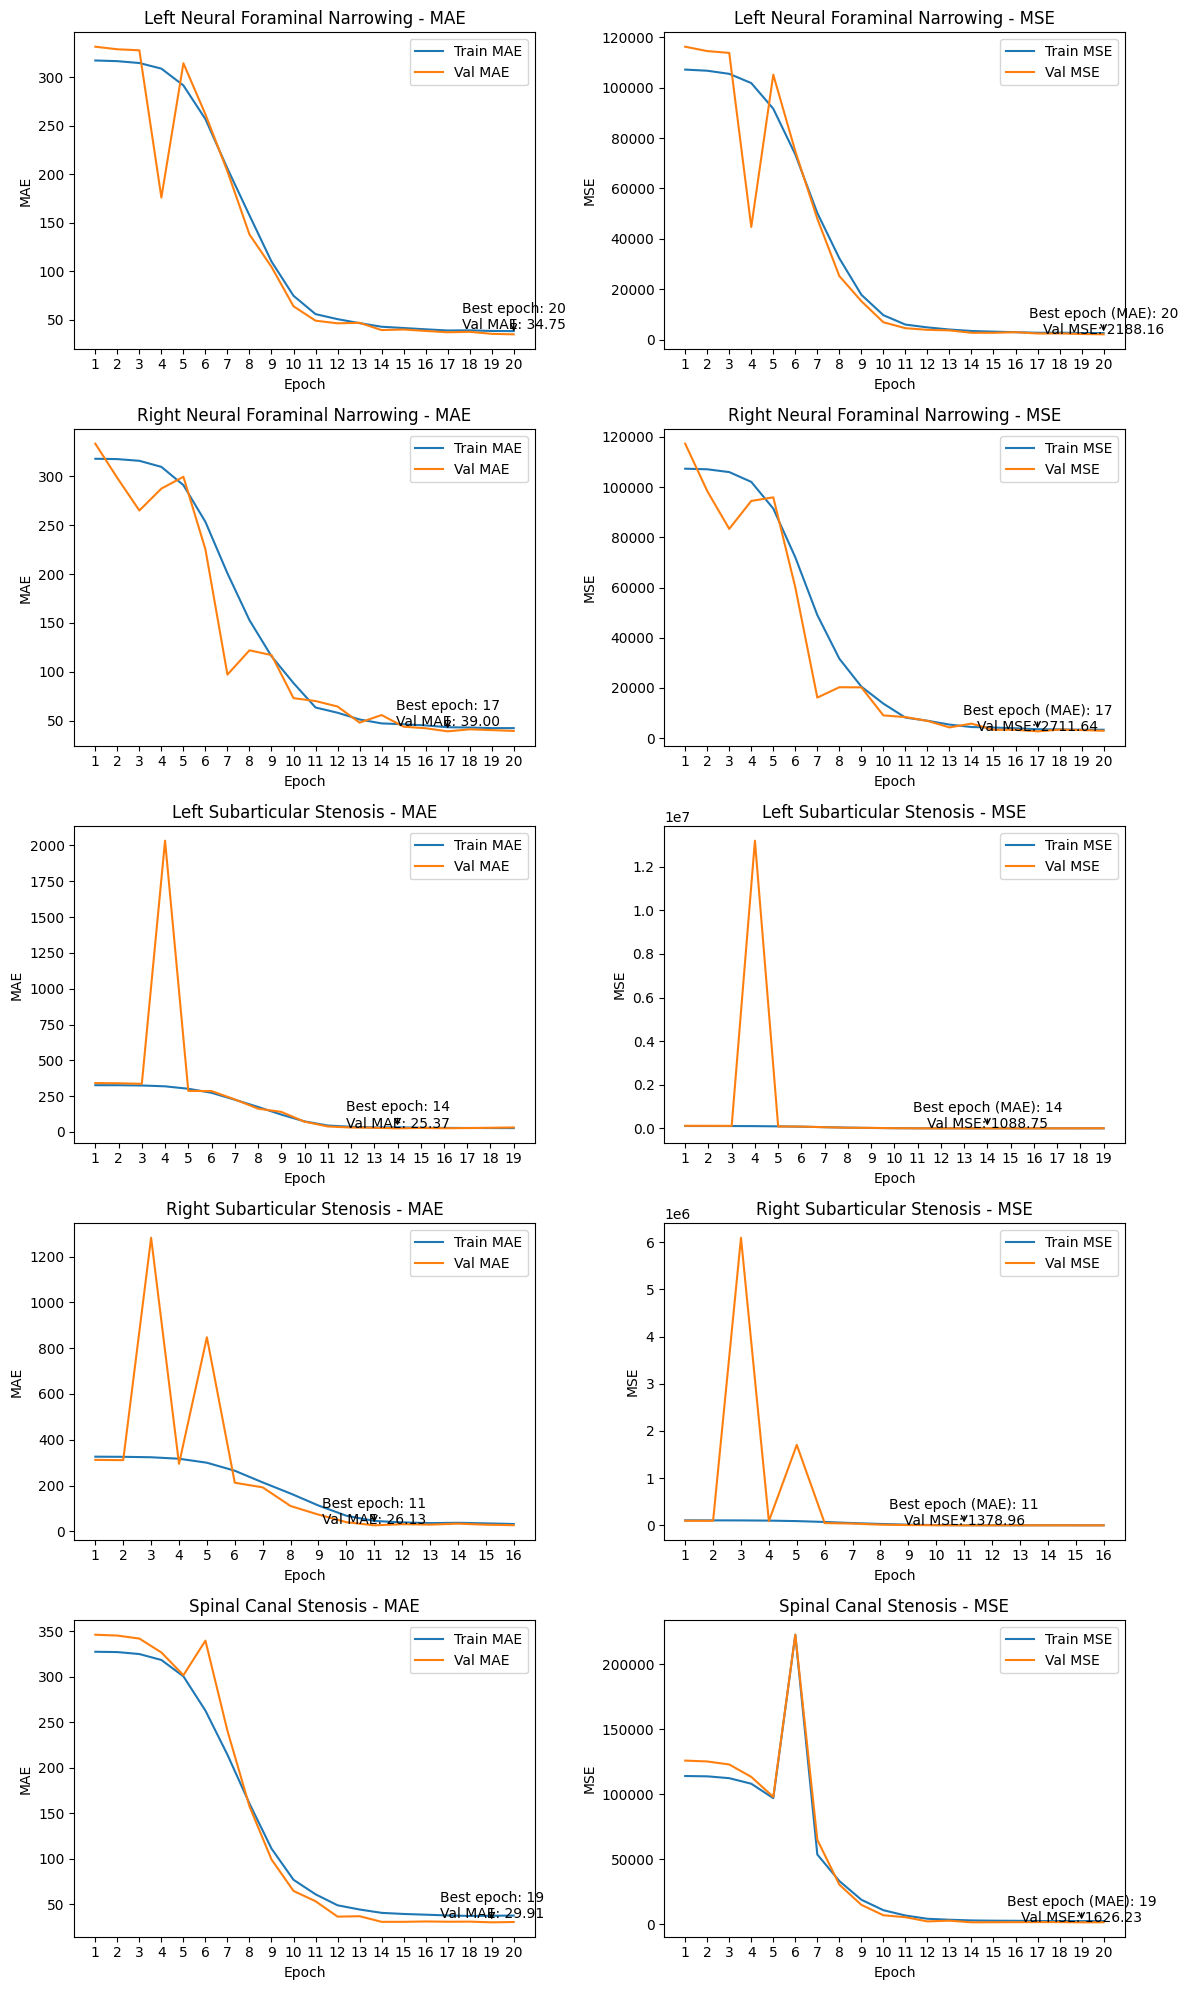

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------
# 1) Data for each condition (MAE & MSE) - extracted directly from your logs
# ------------------------------------------------------------------------

# A) Left Neural Foraminal Narrowing (LNFN): 20 epochs
lnfn_train_mae = [
    317.5643, 316.8649, 314.9374, 309.1440, 291.8049,
    257.0152, 205.9838, 157.6104, 109.9685, 74.5798,
    55.6358, 50.4495, 46.3039, 42.5982, 41.2753,
    39.9483, 38.7215, 38.8937, 38.2510, 38.0889
]
lnfn_val_mae = [
    331.7846, 329.1286, 328.0798, 176.0331, 314.7384,
    261.9301, 203.0358, 137.8942, 104.4127, 63.7173,
    48.8658, 46.1367, 46.6382, 39.1517, 39.7620,
    38.2726, 36.8994, 37.3741, 35.2796, 34.7532
]
lnfn_train_mse = [
    107109.7050, 106660.7583, 105425.9764, 101766.2319, 91596.8109,
    73488.1728, 50274.5617, 32331.4007, 17867.4386, 9776.8643,
    6057.8764, 4937.5677, 4097.2137, 3517.2528, 3266.4077,
    3037.4931, 2810.9729, 2863.9761, 2703.5170, 2682.4887
]
lnfn_val_mse = [
    116177.4414, 114446.8058, 113724.3561, 44735.6059, 105112.1076,
    74775.3232, 48005.3579, 25276.0051, 15326.9850, 6973.7958,
    4629.8709, 3977.7643, 3758.1773, 2801.7661, 2793.0469,
    3044.5753, 2520.0660, 2542.0842, 2329.4029, 2188.1574
]

# B) Right Neural Foraminal Narrowing (RNFN): 20 epochs
rnfn_train_mae = [
    317.9453, 317.5944, 315.8488, 309.6351, 291.0063,
    253.3403, 200.6820, 152.7410, 115.8425, 88.3765,
    63.4010, 58.0434, 51.1334, 47.1342, 46.2081,
    45.0678, 43.1971, 42.9120, 42.3038, 42.2859
]
rnfn_val_mae = [
    333.3435, 298.2962, 264.9857, 287.4066, 299.4799,
    225.2689, 97.0553, 121.9027, 117.0411, 72.9597,
    70.0279, 64.3967, 47.9251, 55.6949, 43.7749,
    42.1551, 39.0031, 41.0681, 40.2727, 39.4124
]
rnfn_train_mse = [
    107313.3329, 107085.5266, 105965.0147, 102064.1392, 91433.6734,
    72017.7717, 49014.5816, 31650.5386, 20513.4971, 13745.3274,
    8181.8212, 6932.4218, 5405.1664, 4431.4209, 4212.1049,
    3927.1181, 3552.8416, 3471.9765, 3355.0182, 3352.7488
]
rnfn_val_mse = [
    117267.1040, 98429.0476, 83344.1144, 94474.5599, 95902.8604,
    60069.4293, 16147.6149, 20276.0807, 20230.1883, 9054.7287,
    8388.0376, 6866.5195, 4283.1501, 5781.5599, 3331.3218,
    3320.3302, 2711.6391, 3376.1625, 3206.5131, 2930.6320
]

# C) Left Subarticular Stenosis (LSAS): 19 epochs (stopped early)
lsas_train_mae = [
    326.4615, 326.3080, 324.4235, 318.5900, 301.6061,
    273.4475, 225.0817, 174.8132, 121.2795, 73.9634,
    45.0136, 36.2346, 31.6511, 32.5623, 29.2273,
    28.5421, 27.8737, 27.3900, 26.9494
]
lsas_val_mae = [
    341.3429, 340.1201, 335.9628, 2032.6693, 286.7189,
    285.3543, 227.3571, 162.6716, 140.2154, 71.8061,
    38.3869, 30.9921, 29.3204, 25.3688, 27.9787,
    25.9789, 27.2437, 29.3734, 31.6300
]
lsas_train_mse = [
    107588.3908, 107483.2650, 106262.9831, 102556.2673, 92474.7447,
    77137.4946, 54210.8464, 33845.3387, 17629.5070, 8500.0105,
    3819.0309, 2796.2213, 2061.2653, 2135.4247, 1541.6972,
    1434.5365, 1292.3218, 1227.1466, 1134.5617
]
lsas_val_mse = [
    117105.1480, 116282.8585, 113587.5903, 13193289.3363, 84507.9548,
    82227.3584, 52321.8404, 28442.6010, 22877.0197, 7482.4331,
    2651.5397, 1900.4634, 1641.7504, 1088.7507, 1254.3861,
    1131.4816, 1434.6390, 2418.8231, 5306.0929
]

# D) Right Subarticular Stenosis (RSAS): 16 epochs (stopped early)
rsas_train_mae = [
    325.9841, 325.3178, 323.4461, 316.9821, 299.5934,
    264.5627, 213.5602, 165.0928, 112.6705, 68.0181,
    45.3725, 39.1199, 35.7861, 37.2924, 34.7101,
    31.9742
]
rsas_val_mae = [
    312.0573, 310.7715, 1282.1242, 294.5959, 847.3766,
    212.2164, 192.0136, 110.4908, 72.9412, 39.9777,
    26.1293, 31.1324, 29.2428, 33.5598, 28.9114,
    26.7245
]
rsas_train_mse = [
    107182.0280, 106751.7861, 105543.7818, 101457.7188, 91235.2970,
    72705.0353, 49627.5759, 30881.1760, 15478.5227, 7265.3286,
    4146.7210, 3464.0078, 2814.4150, 2962.1974, 2534.2824,
    2095.6369
]
rsas_val_mse = [
    98325.6409, 97538.8449, 6091788.0209, 90032.4811, 1705334.3499,
    49810.2751, 38145.3406, 15864.0776, 6920.4521, 3512.7654,
    1378.9571, 1792.1702, 1686.7836, 2360.6901, 1588.5001,
    1443.9960
]

# E) Spinal Canal Stenosis (SCS): 20 epochs
scs_train_mae = [
    327.5293, 327.1784, 325.0205, 318.5030, 300.4952,
    262.7936, 214.2711, 160.5907, 111.0302, 76.7089,
    60.7638, 48.6641, 44.0338, 40.3399, 39.1329,
    38.3373, 37.4838, 36.9505, 37.1428, 37.3427
]
scs_val_mae = [
    346.2810, 345.3400, 342.0348, 326.7732, 301.7047,
    339.7703, 240.5967, 157.4726, 99.0784, 64.4449,
    53.1184, 36.1931, 36.6464, 30.4696, 30.4917,
    30.8805, 30.5927, 30.7015, 29.9126, 30.3108
]
scs_train_mse = [
    114159.8022, 113924.9938, 112493.5529, 108230.7724, 97151.0060,
    222837.9251, 53785.6230, 33400.9419, 19002.8252, 10958.0143,
    6881.6264, 4365.0072, 3631.5757, 3087.4885, 2894.8482,
    2815.0422, 2648.1213, 2553.8105, 2567.8440, 2597.2334
]
scs_val_mse = [
    126019.0770, 125358.5552, 123040.5625, 113506.1318, 98095.7589,
    222837.9251, 65066.3989, 30612.0399, 15071.0687, 7055.9668,
    5583.7362, 2349.8388, 2918.4904, 1644.2697, 1711.9169,
    1766.0581, 1812.6218, 1816.4538, 1626.2296, 1687.5633
]


# ------------------------------------------------------------------------
# 2) UTILITY: Function to plot a single condition's (MAE, MSE) subplots
# ------------------------------------------------------------------------
def plot_regression(ax_mae, ax_mse,
                    train_mae, val_mae,
                    train_mse, val_mse,
                    title_str):
    """
    ax_mae, ax_mse : matplotlib Axes objects for the MAE and MSE subplots
    train_mae, val_mae, train_mse, val_mse : lists of metric values
    title_str : label/title for this condition's row
    """

    epochs = np.arange(1, len(train_mae) + 1)

    # ---- MAE subplot ----
    ax_mae.plot(epochs, train_mae, label='Train MAE')
    ax_mae.plot(epochs, val_mae, label='Val MAE')
    ax_mae.set_title(f'{title_str} - MAE')
    ax_mae.set_xlabel('Epoch')
    ax_mae.set_ylabel('MAE')
    ax_mae.set_xticks(epochs)
    ax_mae.legend(loc='best')

    # Find best epoch (lowest val_mae)
    best_epoch_idx = np.argmin(val_mae)
    best_epoch_num = best_epoch_idx + 1
    best_val_mae = val_mae[best_epoch_idx]

    # Annotate on MAE subplot
    mae_text = f'Best epoch: {best_epoch_num}\nVal MAE: {best_val_mae:.2f}'
    ax_mae.annotate(
        mae_text,
        xy=(best_epoch_num, best_val_mae),
        xytext=(best_epoch_num, best_val_mae + 5),
        arrowprops=dict(arrowstyle='->', color='black'),
        ha='center'
    )

    # ---- MSE subplot ----
    ax_mse.plot(epochs, train_mse, label='Train MSE')
    ax_mse.plot(epochs, val_mse, label='Val MSE')
    ax_mse.set_title(f'{title_str} - MSE')
    ax_mse.set_xlabel('Epoch')
    ax_mse.set_ylabel('MSE')
    ax_mse.set_xticks(epochs)
    ax_mse.legend(loc='best')

    # MSE at that same best epoch
    best_val_mse = val_mse[best_epoch_idx]
    mse_text = (f'Best epoch (MAE): {best_epoch_num}\n'
                f'Val MSE: {best_val_mse:.2f}')
    ax_mse.annotate(
        mse_text,
        xy=(best_epoch_num, best_val_mse),
        xytext=(best_epoch_num, best_val_mse + 5),
        arrowprops=dict(arrowstyle='->', color='black'),
        ha='center'
    )


# ------------------------------------------------------------------------
# 3) MAIN PLOTTING (5 rows × 2 columns)
# ------------------------------------------------------------------------
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))

# Row 1: Left Neural Foraminal Narrowing
plot_regression(
    axes[0, 0],
    axes[0, 1],
    lnfn_train_mae,
    lnfn_val_mae,
    lnfn_train_mse,
    lnfn_val_mse,
    "Left Neural Foraminal Narrowing"
)

# Row 2: Right Neural Foraminal Narrowing
plot_regression(
    axes[1, 0],
    axes[1, 1],
    rnfn_train_mae,
    rnfn_val_mae,
    rnfn_train_mse,
    rnfn_val_mse,
    "Right Neural Foraminal Narrowing"
)

# Row 3: Left Subarticular Stenosis
plot_regression(
    axes[2, 0],
    axes[2, 1],
    lsas_train_mae,
    lsas_val_mae,
    lsas_train_mse,
    lsas_val_mse,
    "Left Subarticular Stenosis"
)

# Row 4: Right Subarticular Stenosis
plot_regression(
    axes[3, 0],
    axes[3, 1],
    rsas_train_mae,
    rsas_val_mae,
    rsas_train_mse,
    rsas_val_mse,
    "Right Subarticular Stenosis"
)

# Row 5: Spinal Canal Stenosis
plot_regression(
    axes[4, 0],
    axes[4, 1],
    scs_train_mae,
    scs_val_mae,
    scs_train_mse,
    scs_val_mse,
    "Spinal Canal Stenosis"
)

plt.tight_layout()
plt.show()


In [ ]:
import torch

# Define the path where you want to save the model
base_dir = "/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/UNet_models"

# Create the directory if it doesn't exist
import os
os.makedirs(os.path.dirname(base_dir), exist_ok=True)

# Loop through and save each model
for model_name, model in models.items():
    # ✅ Fix: Replace spaces with underscores in filenames
    clean_model_name = model_name.replace(" ", "_").replace("/", "_")

    save_path = os.path.join(base_dir, f"{clean_model_name}.pth")  # Save each model with its name
    torch.save(model.state_dict(), save_path)
    print(f"✅ Model {model_name} saved to {save_path}")

print(f"Models saved to {base_dir}")
